this code is a compilation of the different models we built to address question 1

For Question 1: predicting score

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.dummy import DummyRegressor

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [6]:
space = pd.read_csv('/Users/arkinsi/Downloads/archive/space.csv') # replace with file directory
space.head()

,id,title,score,upvote_ratio,num_comments,created_utc,subreddit,subscribers,permalink,url,domain,num_awards,num_crossposts,crosspost_subreddits,post_type,is_nsfw,is_bot,is_megathread,body
0,frdd1d,I'm 17 years old and just finished building th...,219755,0.92,4984,2020-03-30 02:38:26,space,26455316,https://www.reddit.com/r/space/comments/frdd1d...,https://i.redd.it/luf6z5ghfop41.jpg,i.redd.it,0,32,NaN,image,False,False,False,NaN
1,62td2v,"Half-naked girls get thousands of upvotes, how...",205010,0.87,2229,2017-04-01 20:56:52,space,26455316,https://www.reddit.com/r/space/comments/62td2v...,http://static3.businessinsider.com/image/56547...,static3.businessinsider.com,0,6,NaN,link,False,False,False,NaN
2,vwv1et,First full-colour Image of deep space from the...,186354,0.95,8193,2022-07-12 03:55:53,space,26455316,https://www.reddit.com/r/space/comments/vwv1et...,https://i.redd.it/upud5pzg32b91.jpg,i.redd.it,0,53,NaN,image,False,False,False,NaN
3,arer0k,"I took nearly 50,000 images of the night sky t...",178819,0.97,3921,2019-02-17 05:30:06,space,26455316,https://www.reddit.com/r/space/comments/arer0k...,https://i.redd.it/d1aehdnbq0h21.jpg,i.redd.it,0,108,NaN,image,False,False,False,NaN
4,l9ovhe,By complete accident I captured a plane crossi...,167304,0.94,1723,2021-02-01 04:50:53,space,26455316,https://www.reddit.com/r/space/comments/l9ovhe...,https://i.redd.it/7vh012zn3re61.jpg,i.redd.it,0,50,NaN,image,False,False,False,NaN


In [7]:
funny = pd.read_csv('/Users/arkinsi/Downloads/archive/funny.csv')
AskReddit = pd.read_csv('/Users/arkinsi/Downloads/archive/AskReddit.csv')
gaming = pd.read_csv('/Users/arkinsi/Downloads/archive/gaming.csv')
aww = pd.read_csv('/Users/arkinsi/Downloads/archive/aww.csv')
Music = pd.read_csv('/Users/arkinsi/Downloads/archive/Music.csv')

In [148]:
# cleaning function

def cleandata(redditcsv):
    redditcsv = redditcsv.drop(columns = ['is_bot'])
    redditcsv['body'] = redditcsv['body'].fillna(0)
    redditcsv['crosspost_subreddits'] = redditcsv['crosspost_subreddits'].fillna(False)
    redditcsv['is_image'] = np.where(redditcsv['post_type'] == 'image', 1, 0)
    redditcsv['is_link'] = np.where(redditcsv['post_type'] == 'link', 1, 0)
    redditcsv['is_text'] = np.where(redditcsv['post_type'] == 'text', 1, 0)
    redditcsv['is_vid'] = np.where(redditcsv['post_type'] == 'video', 1, 0)
    # one hot encoding for post_types
    
    redditcsv['number_words'] = redditcsv['title'].apply(lambda x: len(x.split())) # determine number of words
    redditcsv.drop(columns = ['url', 'permalink', 'is_megathread'], inplace = True) 
    redditcsv['created_utc'] = pd.to_datetime(redditcsv['created_utc'])
    redditcsv['created_utc_timeonly'] = redditcsv['created_utc'].dt.time
        
    redditcsv.loc[(redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-10 06:00:00').time()) & (redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 00:00:00').time()), 'late_night?'] = 1
    redditcsv.loc[redditcsv['late_night?'].isna(), 'late_night?'] = 0

    
    redditcsv.loc[(redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-10 12:00:00').time()) & (redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 06:00:00').time()), 'morning?'] = 1
    redditcsv.loc[redditcsv['morning?'].isna(), 'morning?'] = 0
    
    redditcsv.loc[(redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-10 18:00:00').time()) & (redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 12:00:00').time()), 'afternoon?'] = 1
    redditcsv.loc[redditcsv['afternoon?'].isna(), 'afternoon?'] = 0
    
    redditcsv.loc[(redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 18:00:00').time()) & (redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-11 23:59:59').time()), 'evening?'] = 1
    redditcsv.loc[redditcsv['evening?'].isna(), 'evening?'] = 0
   
    # one hot encoding for times
    redditcsv.loc[redditcsv['body'] != 0, 'body_fill?'] = 1
    redditcsv.loc[redditcsv['body'] == 0, 'body_fill?'] = 0
    
    # check if there is a body
                                                        
    redditcsv['is_nsfw'] = redditcsv['is_nsfw'].astype(int)

    redditcsv.loc[redditcsv['crosspost_subreddits'] == False, 'crossposted?'] = 0
    redditcsv.loc[redditcsv['crosspost_subreddits'] != False, 'crossposted?'] = 1
    
    # check if crosspost_subreddits
    redditcsv.drop(columns = ['id', 'title', 'upvote_ratio', 'created_utc', 'subreddit', 'subscribers', 'domain', 'num_awards', 'crosspost_subreddits', 'created_utc_timeonly', 'body', 'post_type'], inplace = True)
    
    # drop unnecessary columns
    return redditcsv
    

In [149]:
spaceclean = cleandata(space)
askclean = cleandata(AskReddit)
gamingclean = cleandata(gaming)
awwclean = cleandata(aww)
musicclean = cleandata(Music)

/var/folders/z_/c3wvqjy50m776ff_2rbr_qfc0000gn/T/ipykernel_2474/871255145.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  redditcsv['crosspost_subreddits'] = redditcsv['crosspost_subreddits'].fillna(False)


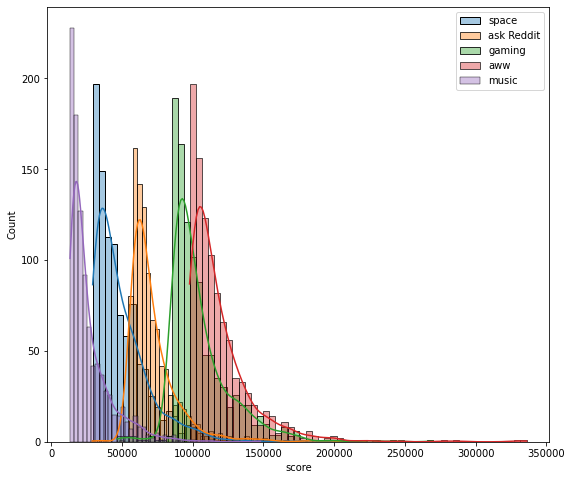

In [154]:
# score visualization

plt.figure(figsize=(9, 8))
sns.histplot(data = spaceclean['score'], kde = True, alpha = 0.4, label = 'space')
sns.histplot(data = askclean['score'], kde = True, alpha = 0.4, label = 'ask Reddit')
sns.histplot(data = gamingclean['score'], kde = True, alpha = 0.4, label = 'gaming')
sns.histplot(data = awwclean['score'], kde = True, alpha = 0.4, label = 'aww')
sns.histplot(data = musicclean['score'], kde = True, alpha = 0.4, label = 'music')

plt.legend()

In [112]:
# correlation plot function

def corrplot(dfs, names):
    index = 0
    for x in dfs:
        test_corr = x.corr(numeric_only = True)
        print(test_corr.iloc[:,0])
        plt.figure(figsize=(24, 24))

        sns.heatmap(test_corr, 
                    cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                    annot=True, annot_kws={"size": 8}, square=True);
        plt.title(names[index])
        plt.show()
        index = index + 1

In [13]:
# basic linear regression function

def linregression(dfs, names):
    for i, d in enumerate(dfs):
        x = d.copy()
        y = x.score
        x.drop(columns = ['score'], inplace = True)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
        model = LinearRegression().fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        plt.scatter(y_test, y_pred_test, color = 'blue', alpha = 0.5)
        min_val = min(min(y_test), min(y_pred_test))  # Find the minimum value for both axes, create y = x line
        max_val = max(max(y_test), max(y_pred_test))  # Find the maximum value for both axes
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        plt.title('predicted y test vs actual y test values ' + names[i])
        plt.show()
        
        dummy_regr = DummyRegressor(strategy="mean")
        dummy_regr.fit(X_train, y_train)
        y_dummy_test = dummy_regr.predict(X_test)
        # compare to dummy regressor
        print("R2 score of model prediction on train set =", r2_score(y_train, y_pred_train))
        print("R2 score of model prediction on test set =", r2_score(y_test, y_pred_test))
        
        print("R2 score of dummy prediction on test set =", r2_score(y_test, y_dummy_test))
        print(model.coef_)

In [14]:
spacecleancondensed = spaceclean[['score', 'num_comments', 'num_crossposts', 'number_words']] 
# a condensed version of space dataset based on features that have higher correlations with score

score             1.000000
num_comments      0.390465
num_crossposts    0.438771
is_nsfw          -0.030075
is_image          0.140729
is_link          -0.153163
is_text           0.038742
is_vid            0.004146
number_words     -0.007685
late_night?       0.104852
morning?         -0.035280
afternoon?       -0.091637
evening?         -0.015896
body_fill?        0.023321
crossposted?     -0.036435
Name: score, dtype: float64


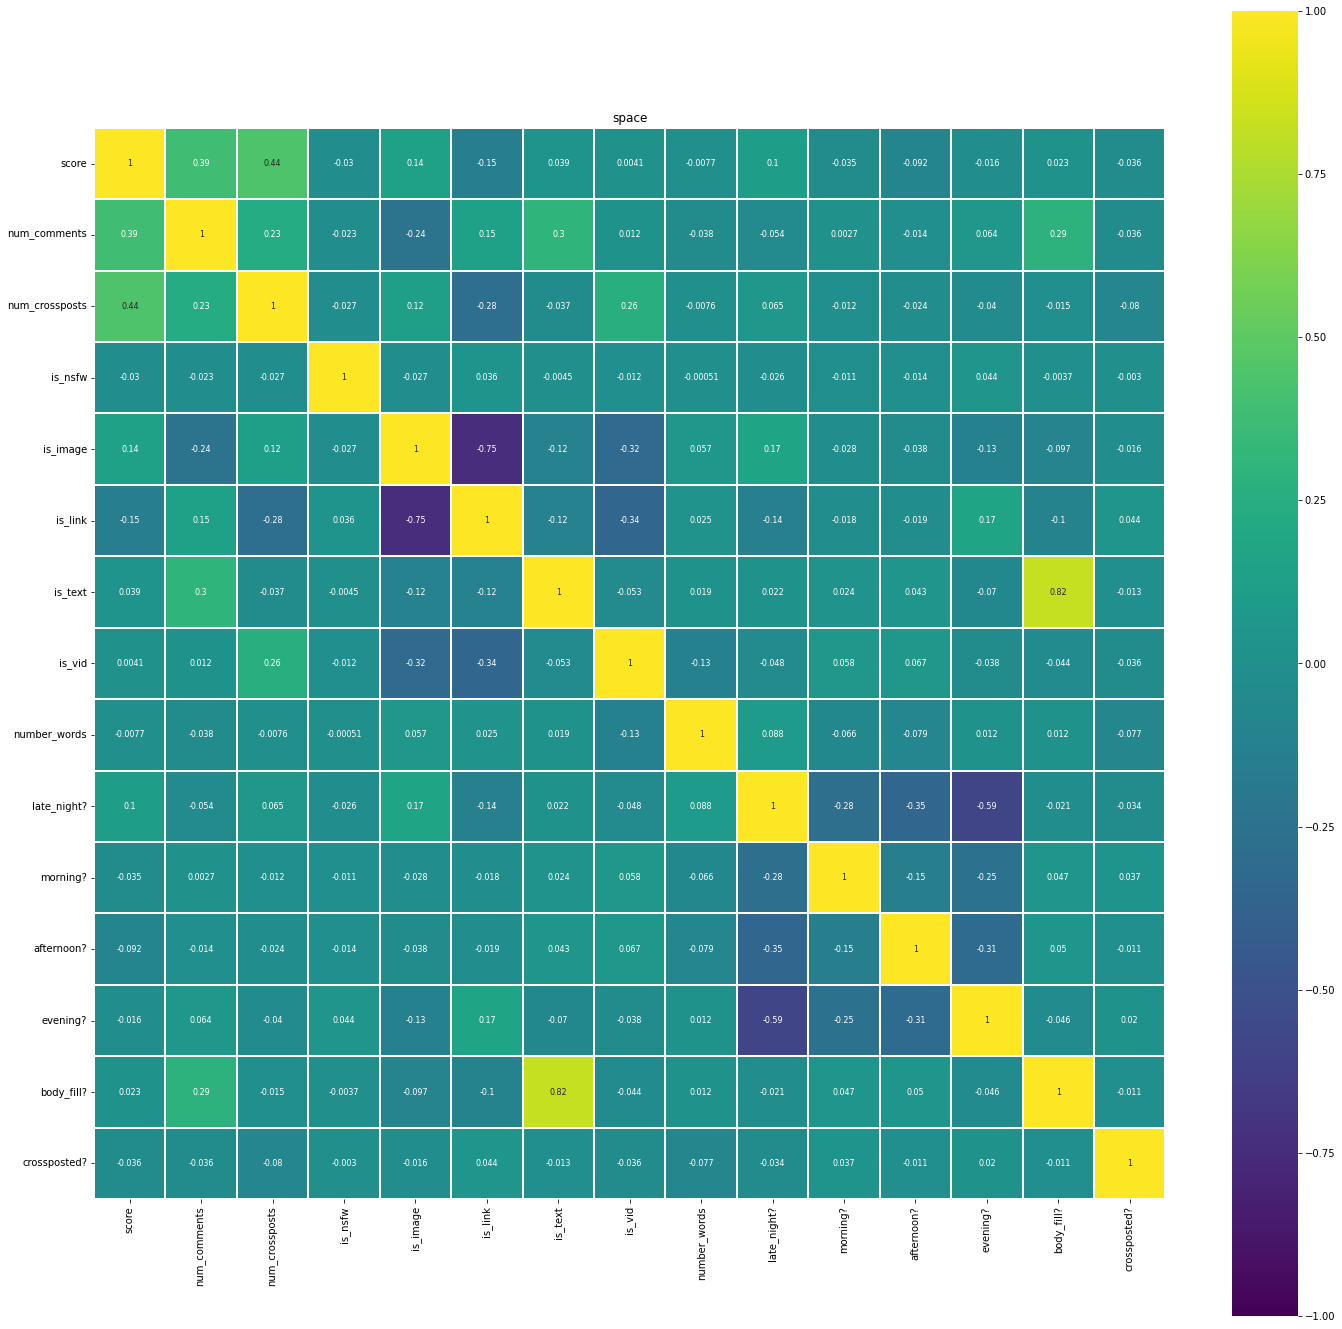

score             1.000000
num_comments     -0.132651
num_crossposts    0.291430
is_nsfw          -0.056255
is_image               NaN
is_link                NaN
is_text                NaN
is_vid                 NaN
number_words      0.230146
late_night?       0.070838
morning?         -0.011729
afternoon?       -0.078609
evening?          0.014477
body_fill?        0.159253
crossposted?           NaN
Name: score, dtype: float64


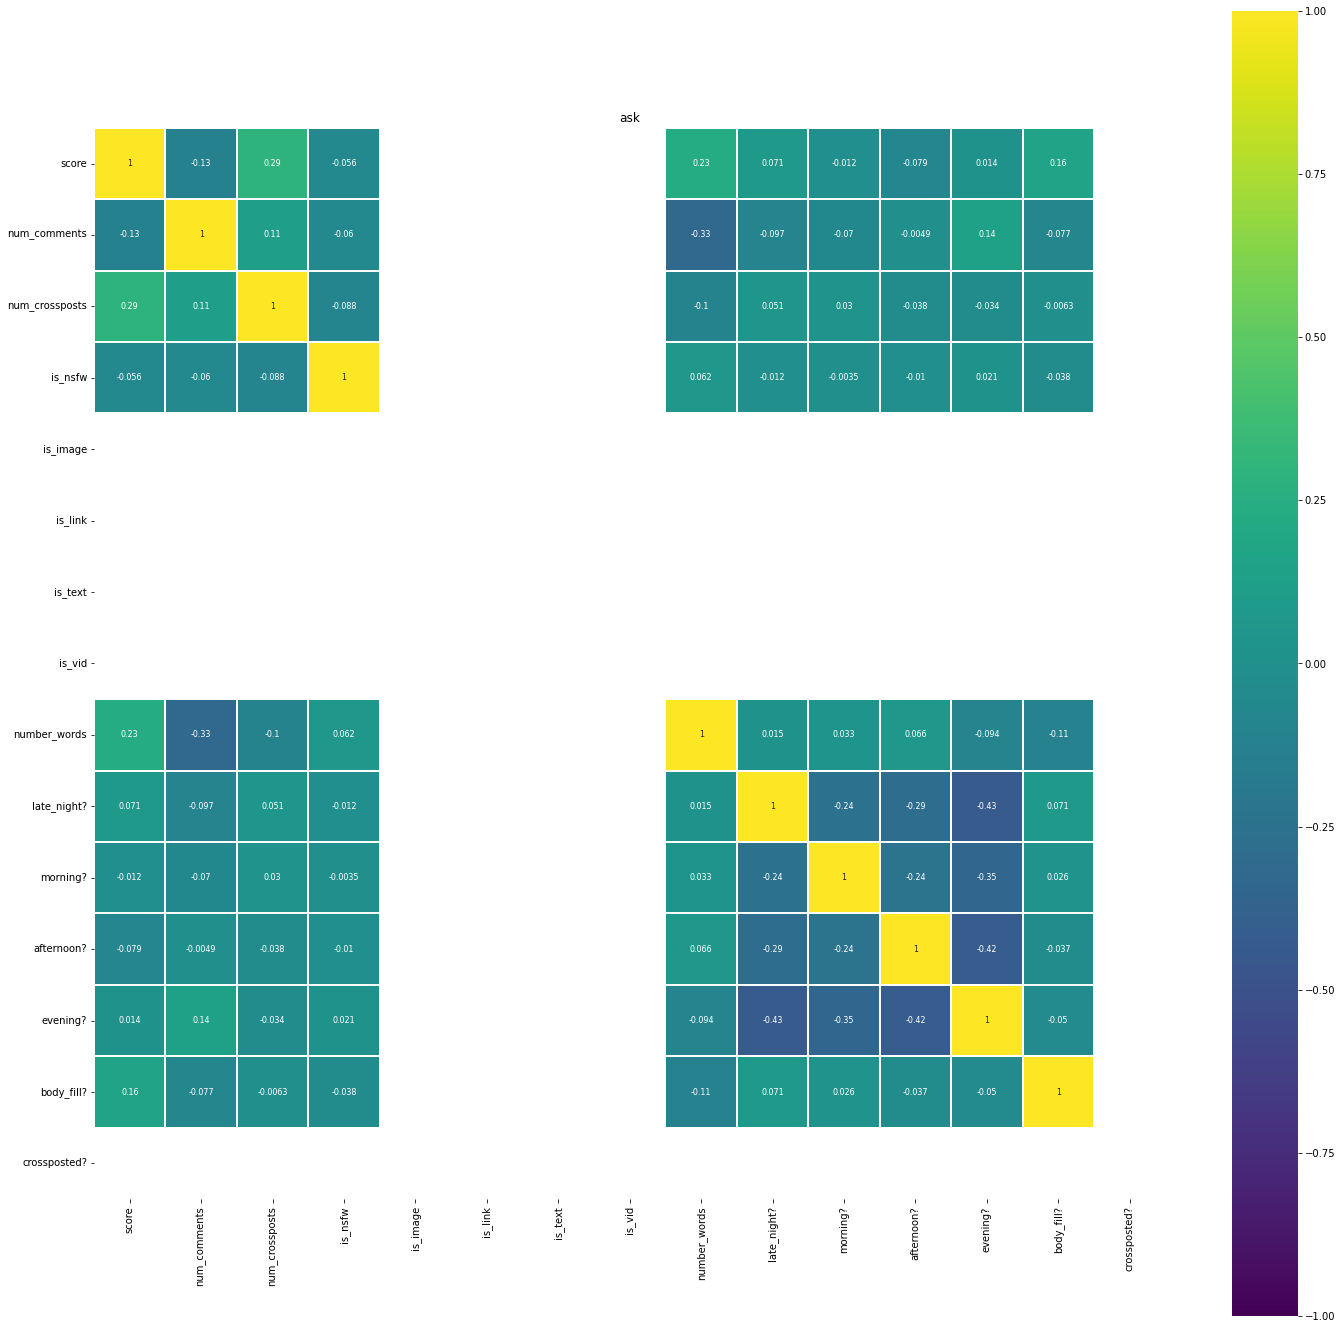

score             1.000000
num_comments      0.284318
num_crossposts    0.355129
is_nsfw          -0.021349
is_image         -0.067263
is_link           0.031183
is_text           0.167286
is_vid                 NaN
number_words      0.106131
late_night?       0.028068
morning?         -0.080210
afternoon?       -0.037391
evening?          0.050895
body_fill?        0.139808
crossposted?      0.029541
Name: score, dtype: float64


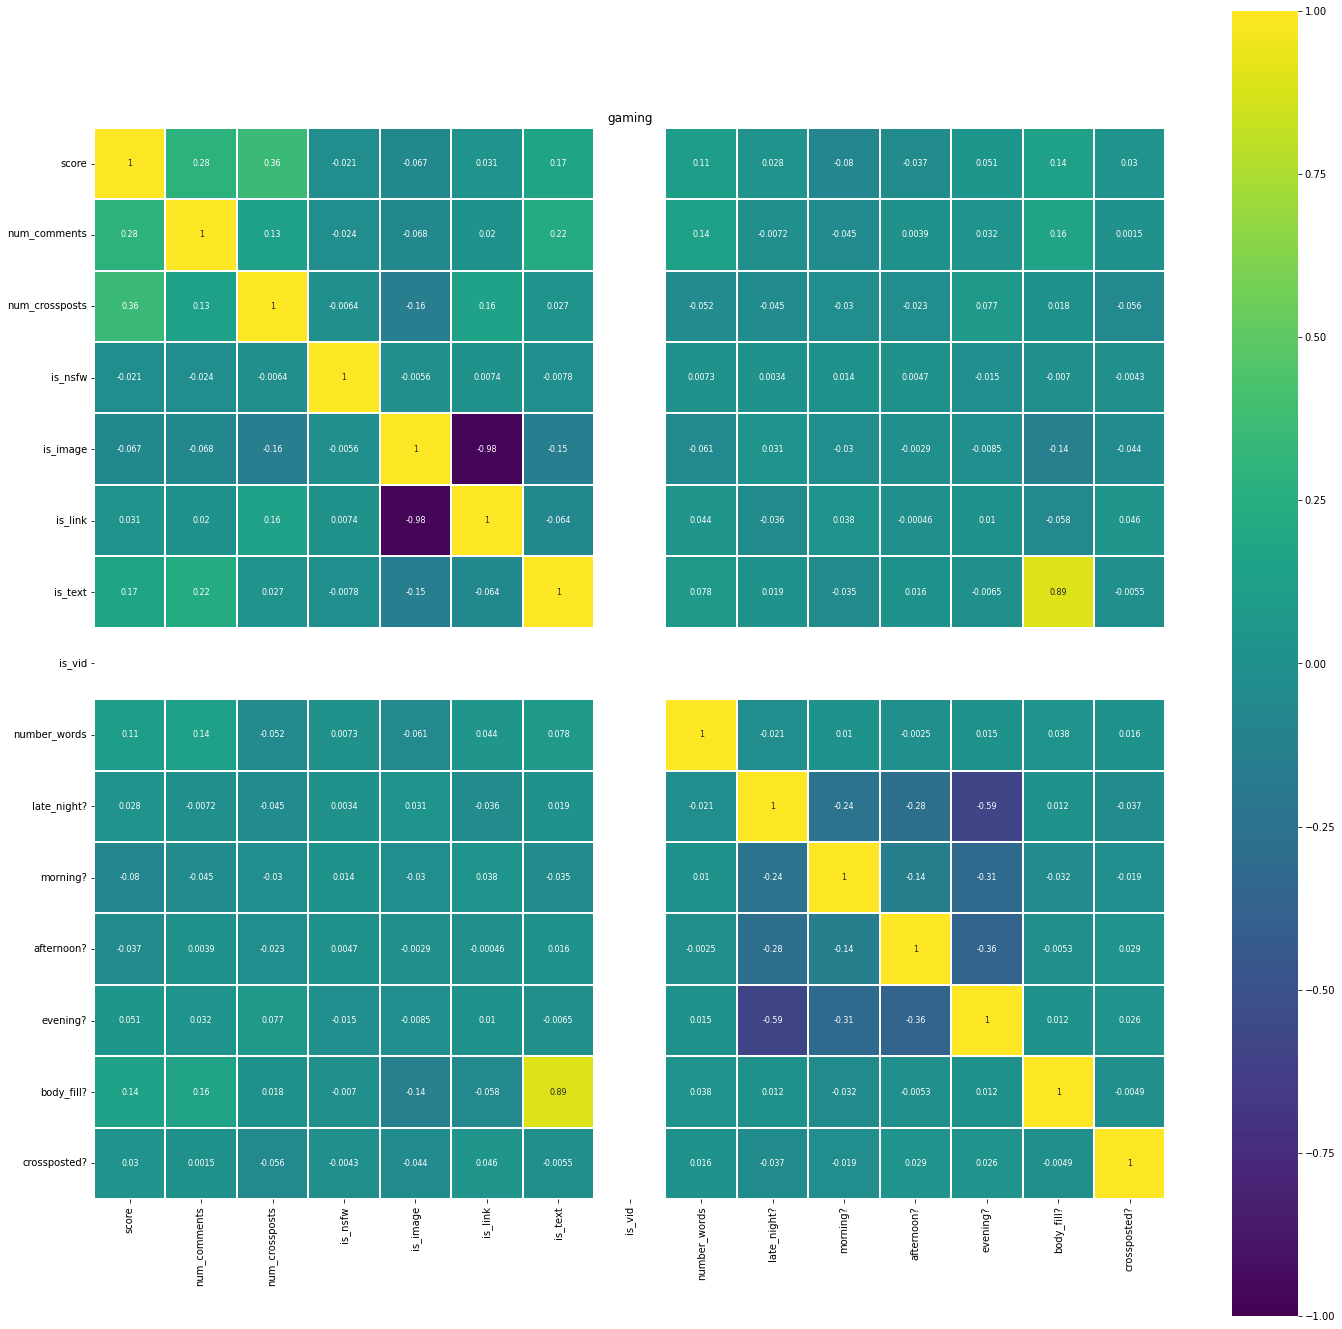

score             1.000000
num_comments      0.486849
num_crossposts    0.533854
is_nsfw                NaN
is_image         -0.017920
is_link          -0.022300
is_text                NaN
is_vid            0.034777
number_words      0.049547
late_night?       0.043052
morning?         -0.015532
afternoon?       -0.012927
evening?         -0.019525
body_fill?             NaN
crossposted?     -0.014263
Name: score, dtype: float64


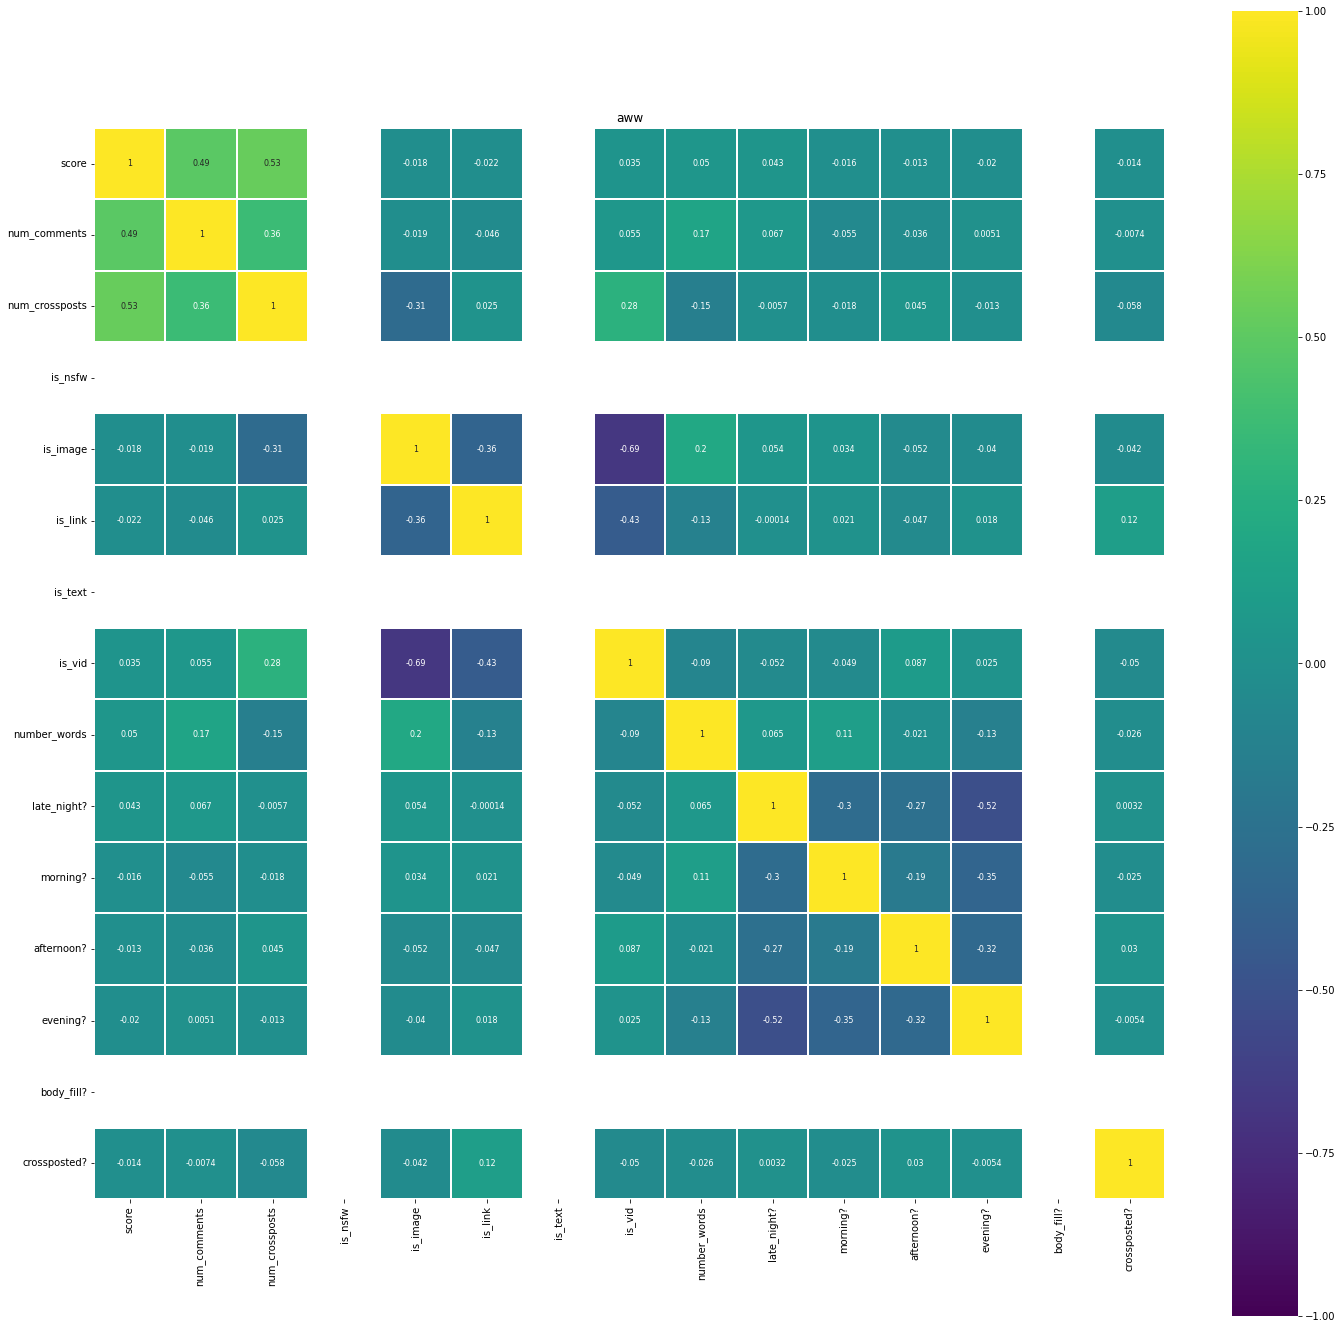

score             1.000000
num_comments      0.266953
num_crossposts    0.264948
is_nsfw          -0.041563
is_image               NaN
is_link           0.001911
is_text           0.000288
is_vid           -0.019870
number_words      0.069901
late_night?       0.052246
morning?          0.009650
afternoon?       -0.062237
evening?         -0.008615
body_fill?        0.000288
crossposted?     -0.003915
Name: score, dtype: float64


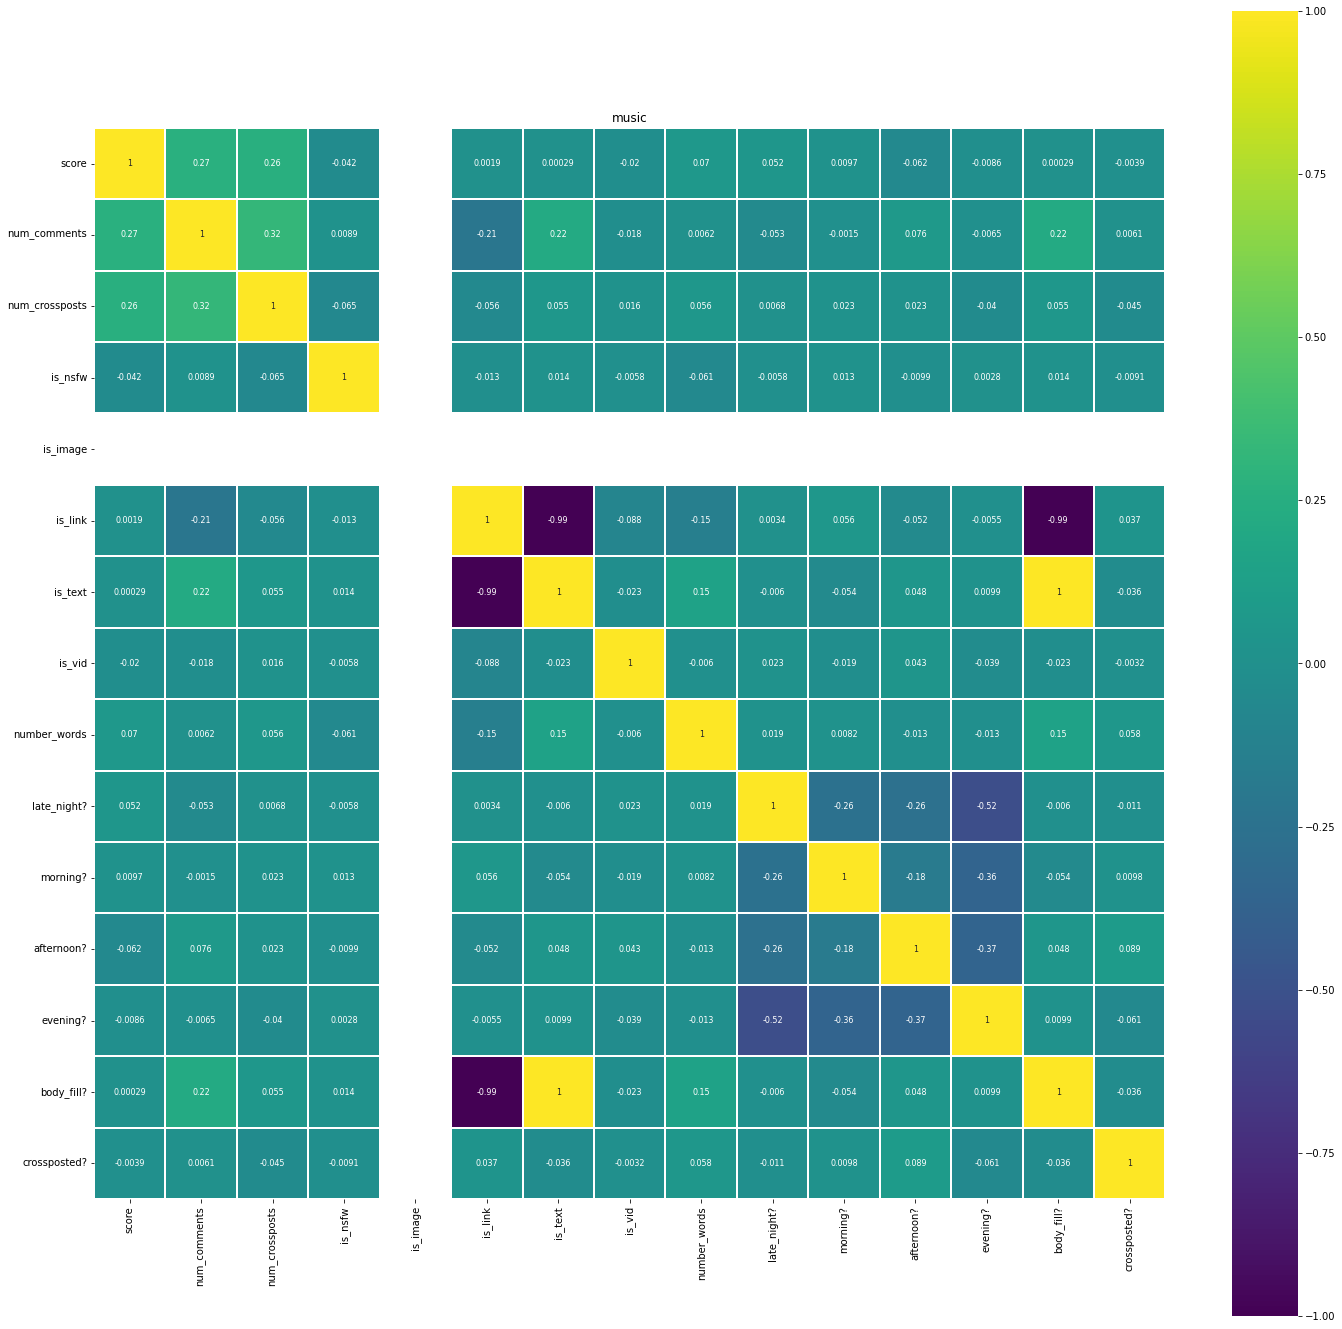

In [15]:
x = [spaceclean, askclean, gamingclean, awwclean, musicclean]
xnames = ['space', 'ask', 'gaming', 'aww', 'music']
corrplot(x, xnames)

score             1.000000
num_comments      0.390465
num_crossposts    0.438771
number_words     -0.007685
Name: score, dtype: float64


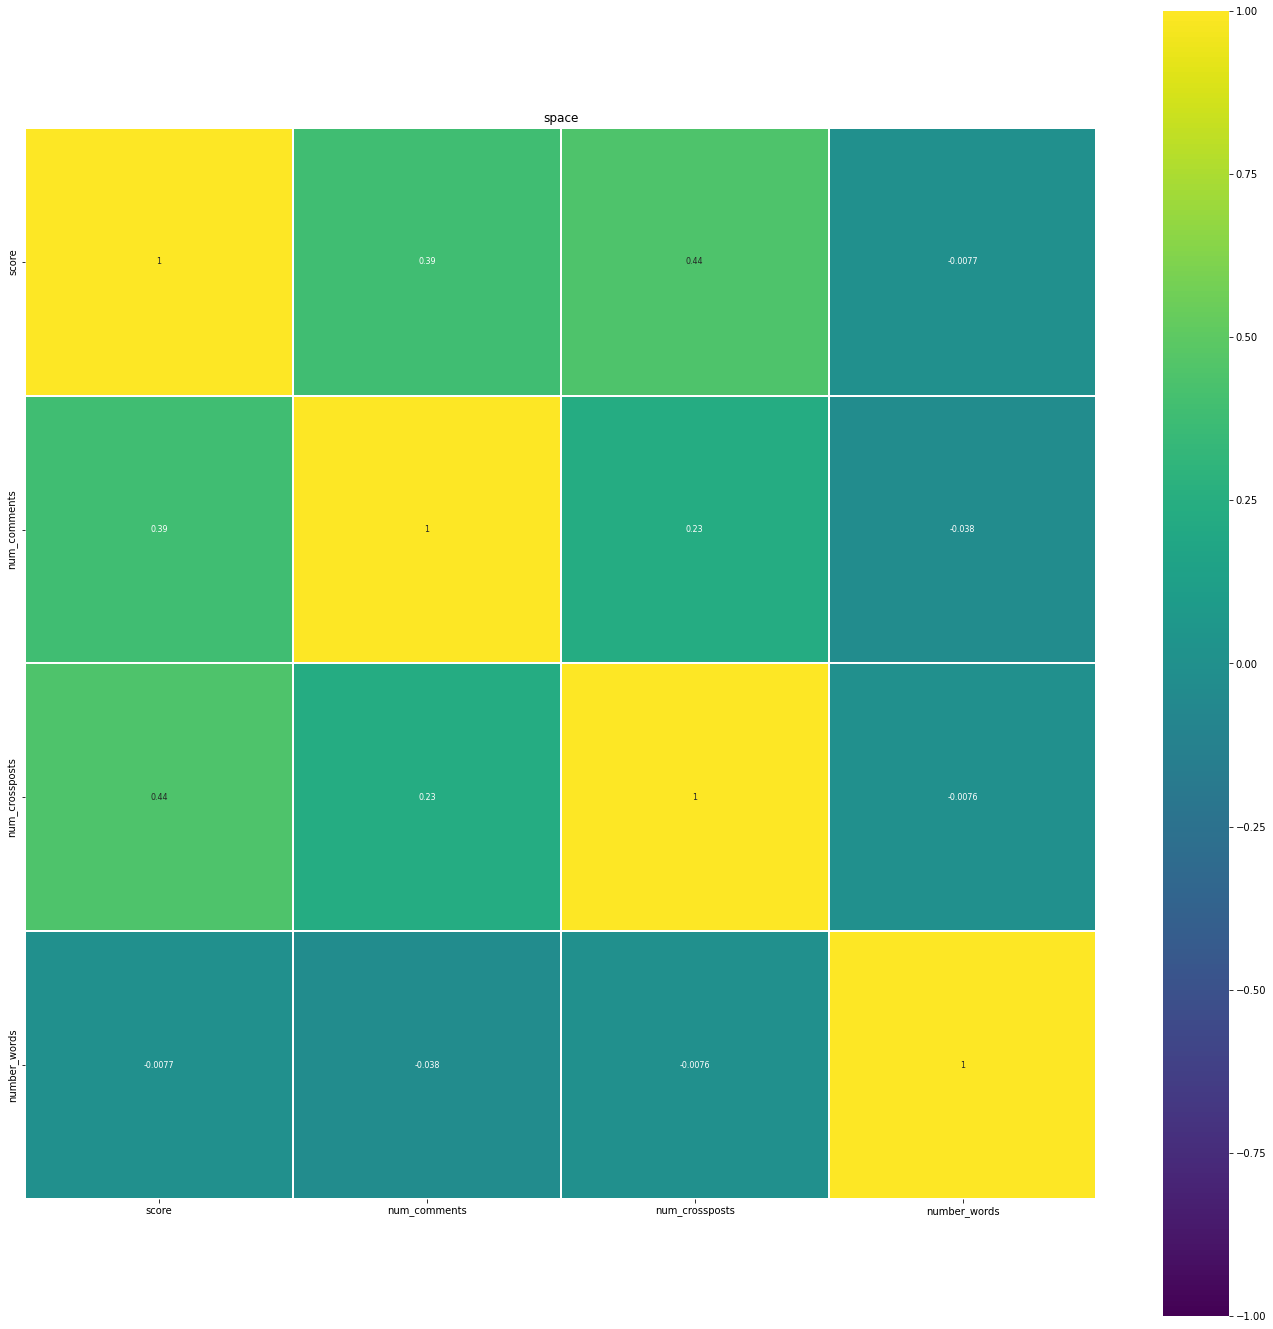

score             1.000000
num_comments     -0.132651
num_crossposts    0.291430
number_words      0.230146
Name: score, dtype: float64


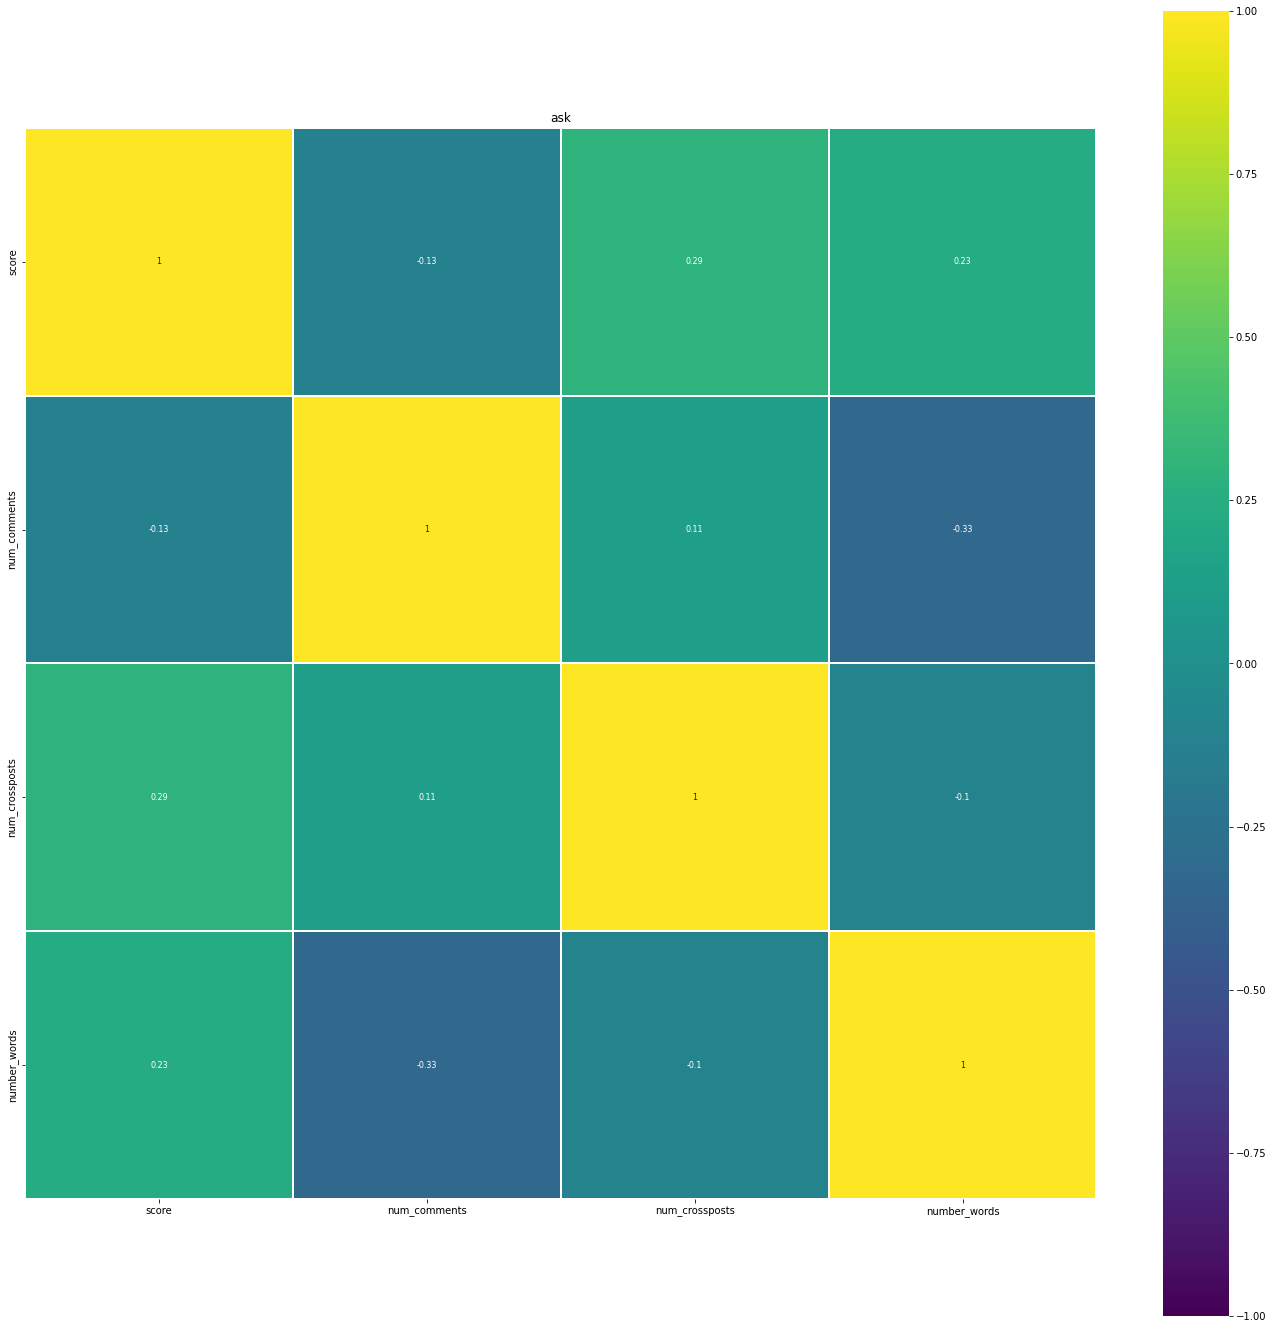

score             1.000000
num_comments      0.284318
num_crossposts    0.355129
number_words      0.106131
Name: score, dtype: float64


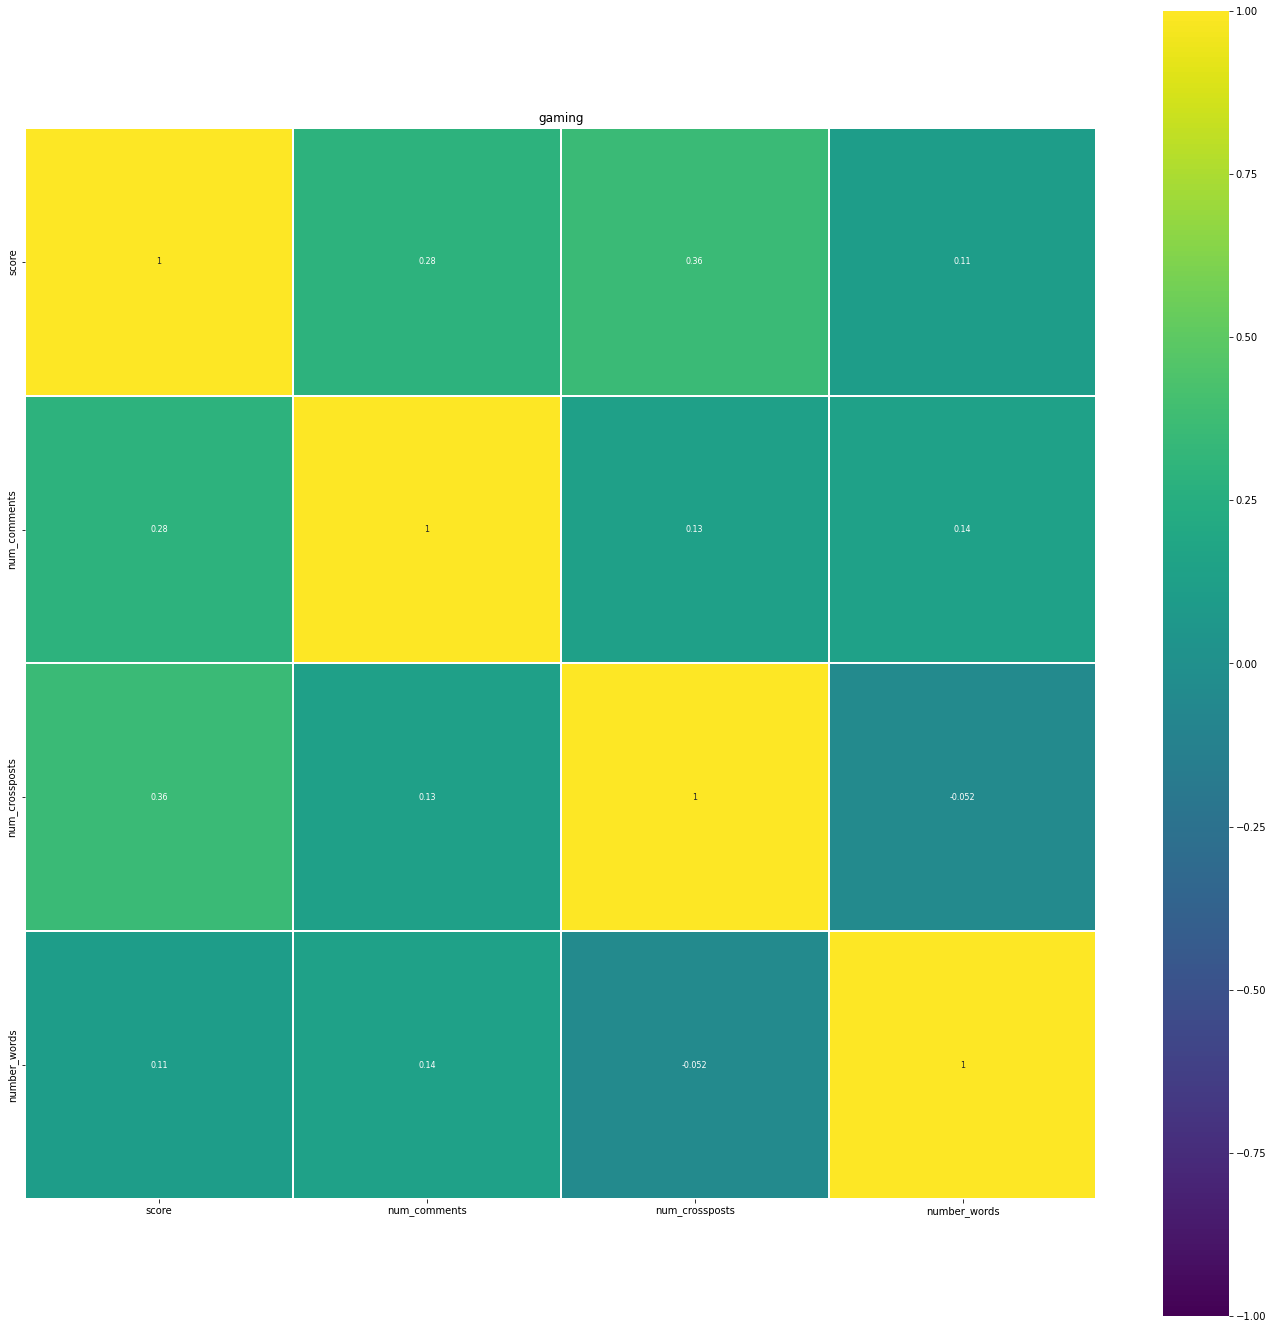

score             1.000000
num_comments      0.486849
num_crossposts    0.533854
number_words      0.049547
Name: score, dtype: float64


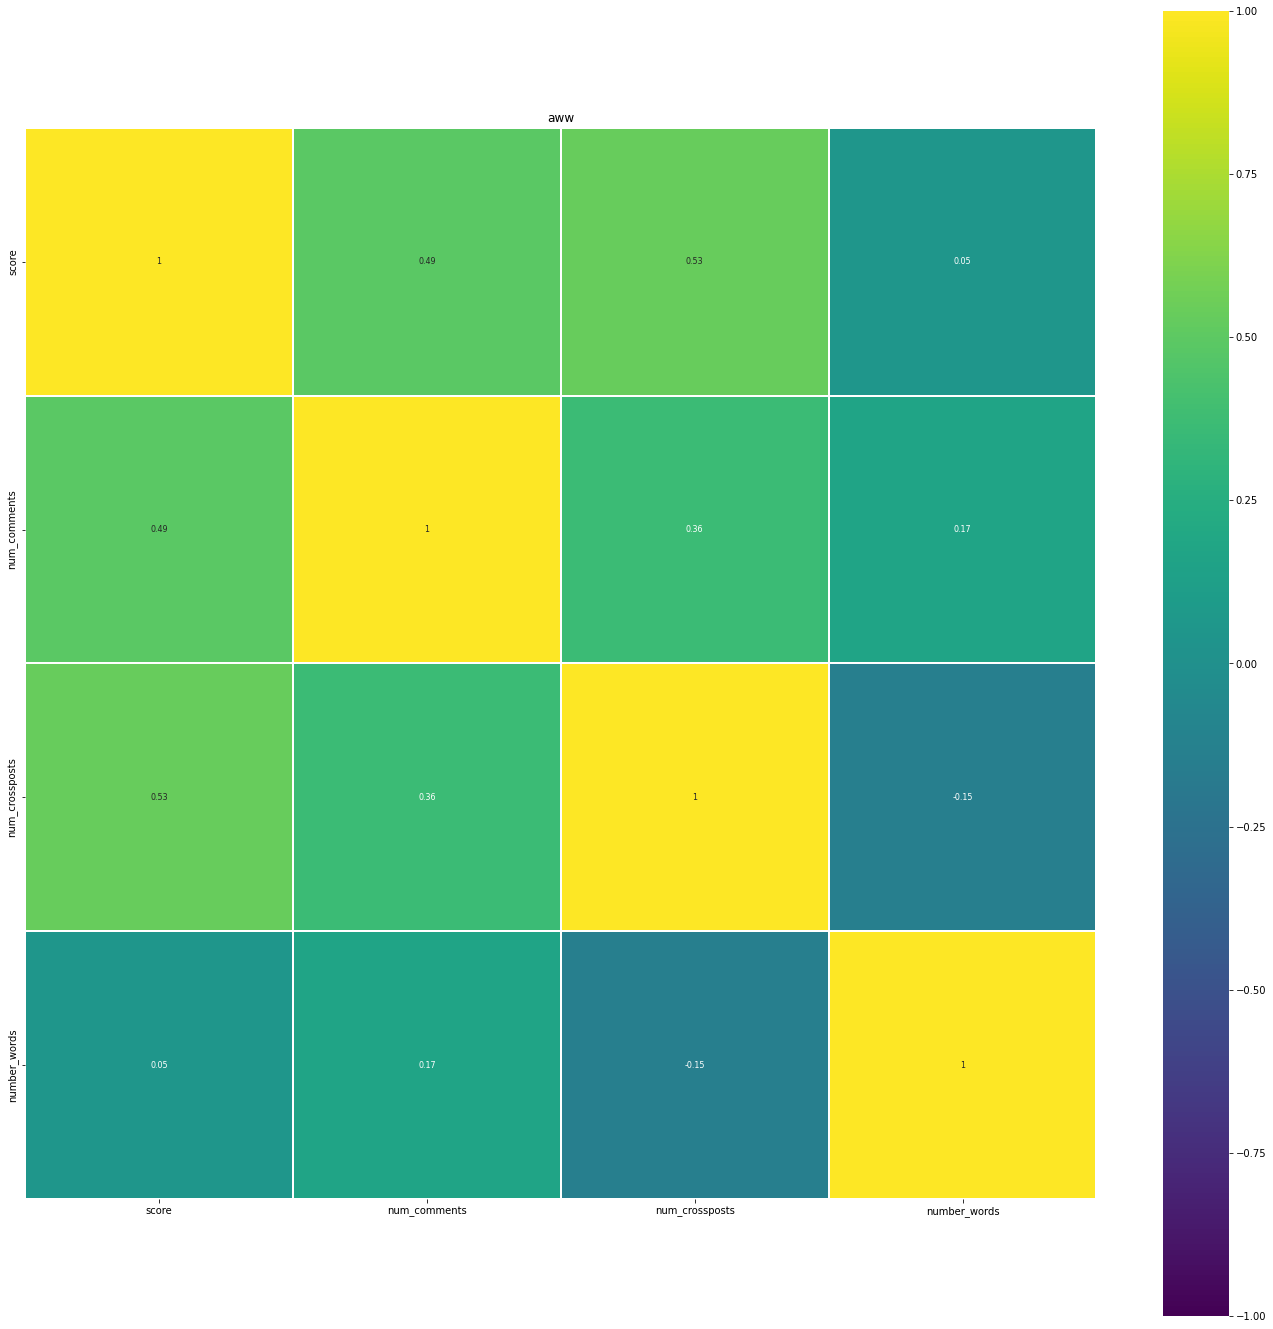

score             1.000000
num_comments      0.266953
num_crossposts    0.264948
number_words      0.069901
Name: score, dtype: float64


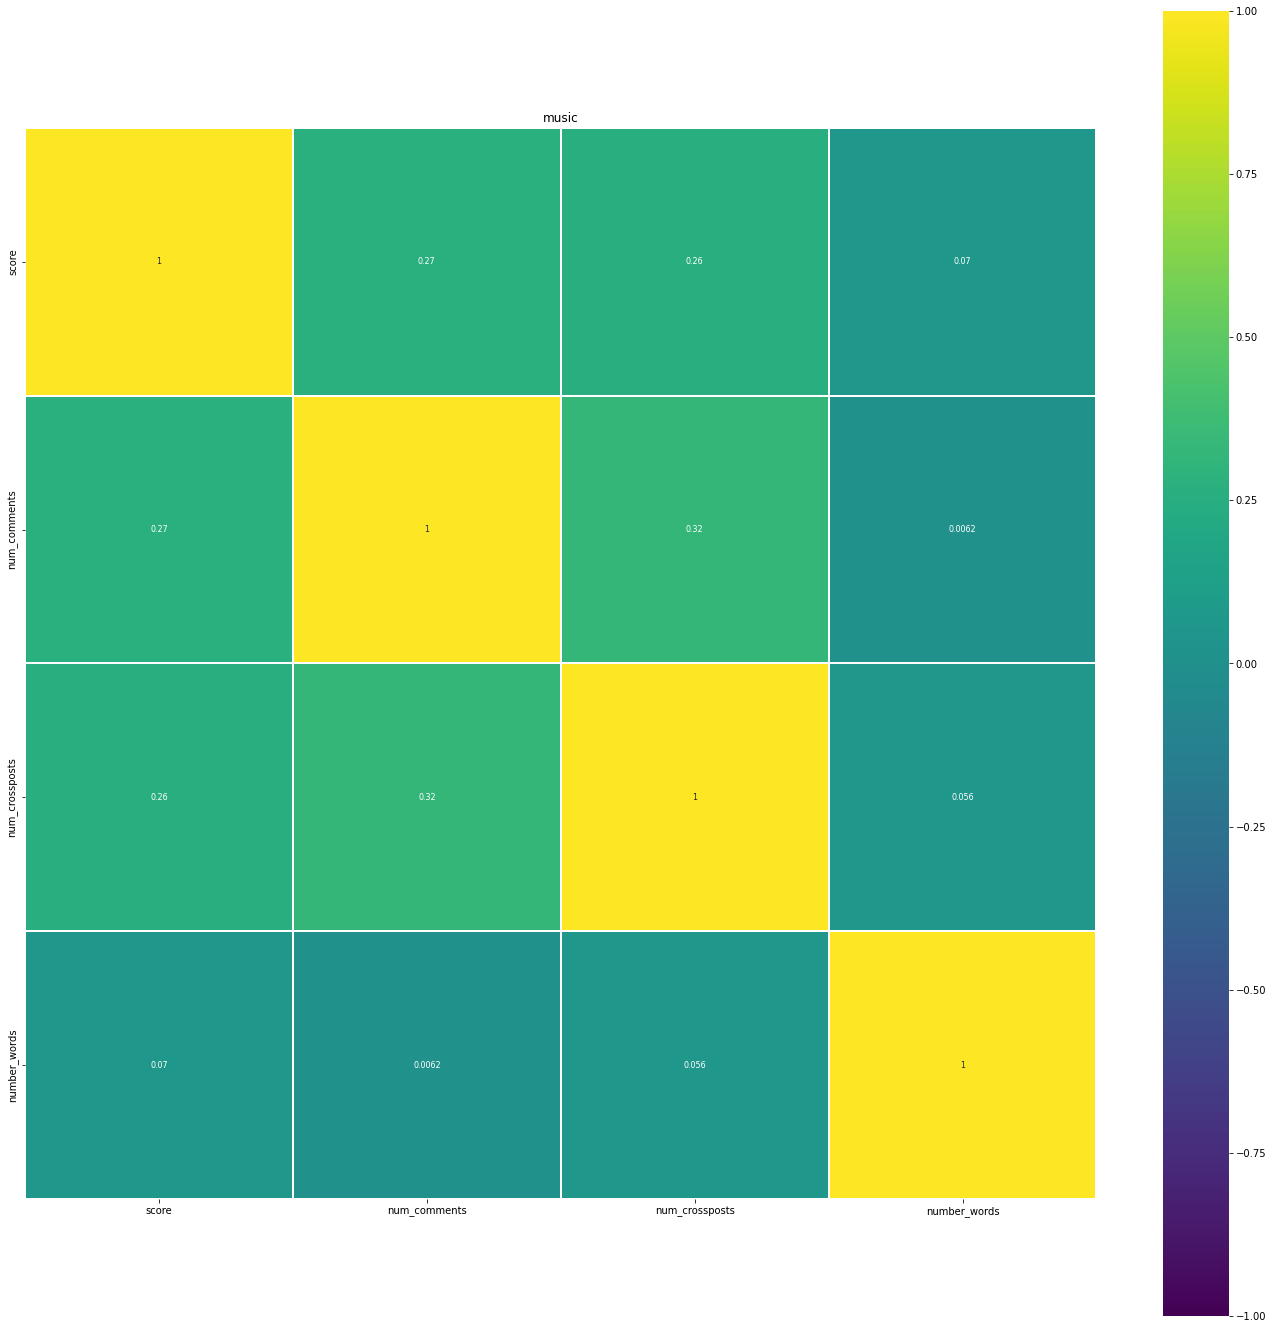

In [113]:
x1 = [spaceclean[['score', 'num_comments', 'num_crossposts', 'number_words']], askclean[['score', 'num_comments', 'num_crossposts', 'number_words']], gamingclean[['score', 'num_comments', 'num_crossposts', 'number_words']], awwclean[['score', 'num_comments', 'num_crossposts', 'number_words']], musicclean[['score', 'num_comments', 'num_crossposts', 'number_words']]]
corrplot(x1, xnames) # condensed datasets based on features with high corrrelations 

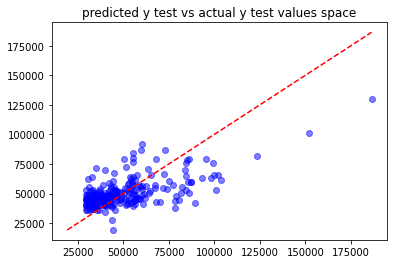

R2 score of model prediction on train set = 0.29476609114057695
R2 score of model prediction on test set = 0.40685289898656396
R2 score of dummy prediction on test set = -4.24463055703761e-06
[ 7.06371781e+00  5.71357332e+02 -5.45696821e-12  6.13948228e+03
 -8.55355422e+02 -3.42900518e+03 -1.85512168e+03 -2.96079206e+01
  2.83751836e+03 -1.61412637e+03 -2.18342092e+03  9.60028924e+02
 -1.48878083e+04  1.47751083e+03]


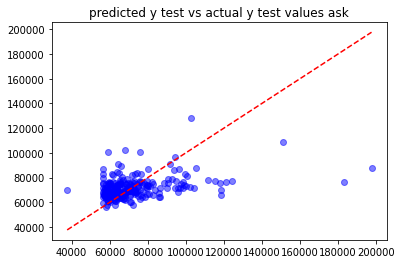

R2 score of model prediction on train set = 0.22545140906846683
R2 score of model prediction on test set = 0.12720016793819677
R2 score of dummy prediction on test set = -0.0001282356317184874
[-1.17261134e-01  5.70817280e+02 -1.74223139e+03  2.09183781e-11
  1.09139364e-11  0.00000000e+00  0.00000000e+00  5.39392151e+02
  1.58434306e+03 -5.87858009e+02 -3.18883295e+03  2.19234790e+03
  3.84557899e+04  0.00000000e+00]


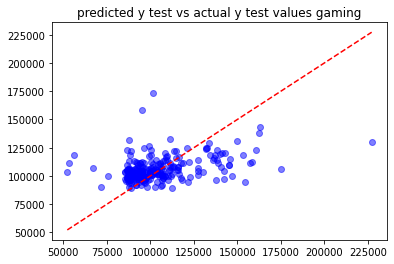

R2 score of model prediction on train set = 0.22351163328955936
R2 score of model prediction on test set = 0.10822688113935175
R2 score of dummy prediction on test set = -0.00020899342567126666
[ 3.69228629e+00  4.69134630e+02  2.43664568e+03  7.92878401e+03
  5.91419520e+03 -1.38429792e+04  0.00000000e+00  2.58537943e+02
  3.37781069e+03 -3.85493323e+03 -1.61023919e+03  2.08736173e+03
  4.13488870e+04  1.89126789e+04]


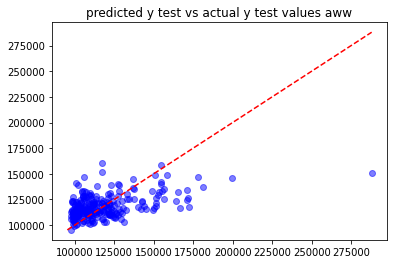

R2 score of model prediction on train set = 0.4436419841130358
R2 score of model prediction on test set = 0.23051476087157274
R2 score of dummy prediction on test set = -0.0008777852265546837
[ 1.05249899e+01  4.82749432e+02 -1.42108547e-12  3.39565312e+03
 -9.40166897e+02 -1.81898940e-12 -2.45548622e+03  2.38213238e+02
  1.04710033e+03  6.79461672e+02 -2.26165859e+03  5.35096587e+02
  0.00000000e+00  9.54486870e+03]


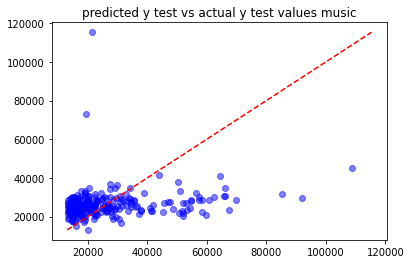

R2 score of model prediction on train set = 0.1611894570735819
R2 score of model prediction on test set = -0.07389396536077708
R2 score of dummy prediction on test set = -4.267546862557481e-06
[ 1.14294319e+00  1.12079317e+03 -4.85031273e+03  1.59161573e-12
  3.28187094e+03  6.47560753e+02 -3.92943169e+03  1.00272264e+02
  3.00169849e+03 -2.85036981e+01 -3.42715130e+03  4.53956506e+02
  6.47560753e+02  8.23879563e+03]


In [152]:
linregression(x, xnames)

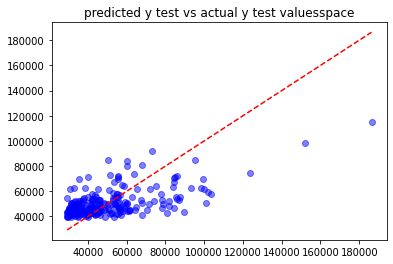

R2 score of model prediction on train set = 0.24988319166355277
R2 score of model prediction on test set = 0.3735722220683759
[  5.43628599 634.61936119   9.94523168]


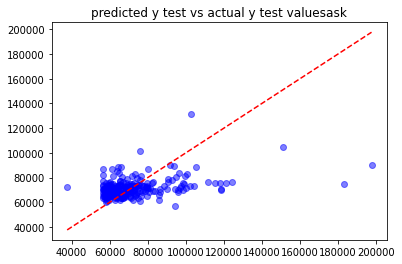

R2 score of model prediction on train set = 0.16522471430605856
R2 score of model prediction on test set = 0.1413300676539796
[-1.57308337e-01  5.83940919e+02  4.49055791e+02]


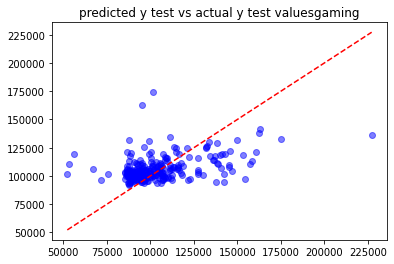

R2 score of model prediction on train set = 0.19763560886554787
R2 score of model prediction on test set = 0.1458466780901283
[  3.96023474 453.82202933 254.26231163]


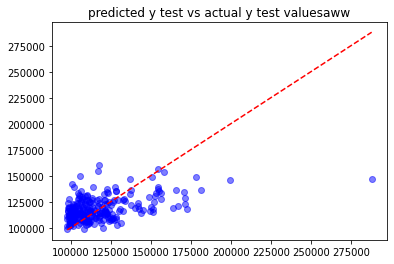

R2 score of model prediction on train set = 0.43055566602198003
R2 score of model prediction on test set = 0.21327917419929665
[ 11.10271576 443.81959805 268.57027783]


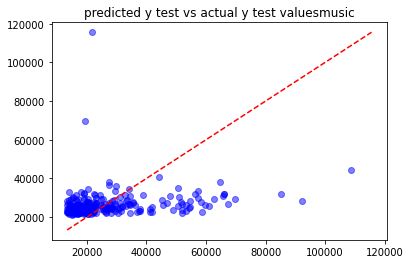

R2 score of model prediction on train set = 0.14005161427605473
R2 score of model prediction on test set = -0.047063735175290944
[9.94336191e-01 1.12001514e+03 9.87730400e+01]


In [45]:
linregression(x1, xnames)

POLYNOMIAL REGRESSION

In [107]:
from sklearn.preprocessing import PolynomialFeatures

In [147]:
# basic polynomial regression

def polyregression(dfs, names, deg):
    print('Degree: ', deg)
    meansqerror = []
    
    for i, d in enumerate(dfs):
        x = d.copy()
        y = x.score
        x.drop(columns = ['score'], inplace = True)
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # scale before applying polynomial transformation
        poly = PolynomialFeatures(degree=deg)
        
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
 
        lin2 = LinearRegression()
        lin2.fit(X_poly_train, y_train)
        
        y_pred_train = lin2.predict(X_poly_train)
        y_pred_test = lin2.predict(X_poly_test)
        
        plt.scatter(y_train, y_pred_train, color = 'blue', alpha = 0.5)
        min_val = min(min(y_train), min(y_pred_train))  
        max_val = max(max(y_train), max(y_pred_train))  
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        plt.title('predicted y train vs actual y train values' + names[i])
        plt.show()
        
        plt.scatter(y_test, y_pred_test, color = 'blue', alpha = 0.5)
        min_val = min(min(y_test), min(y_pred_test))  
        max_val = max(max(y_test), max(y_pred_test))  
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        plt.title('predicted y test vs actual y test values for ' + names[i])
        plt.show()
        
        dummy_regr = DummyRegressor(strategy="mean")
        dummy_regr.fit(X_train, y_train)
        y_dummy_test = dummy_regr.predict(X_poly_test)
        
        print("R2 score of model prediction on train set =", r2_score(y_train, y_pred_train))
        print("R2 score of model prediction on test set =", r2_score(y_test, y_pred_test))
        
        print("R2 score of dummy prediction on test set =", r2_score(y_test, y_dummy_test))
        
        
        meansqerror.append(mean_squared_error(y_train, y_pred_train) - mean_squared_error(y_test, y_pred_test))
    return meansqerror

In [105]:
# polynomial regression with scaling and ridge regression

def polyregressionridge(dfs, names, deg):
    print('Degree: ', deg)
    meansqerrordiff = []
    
    for i, d in enumerate(dfs):
        x = d.copy()
        y = x.score
        x.drop(columns = ['score'], inplace = True)
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        poly = PolynomialFeatures(degree=deg)
        
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
 
        ridge = Ridge()
        alphas = [0.01, 0.1, 1.0, 10, 100]
        param_grid = {'alpha': alphas}
        grid_search = GridSearchCV(ridge, param_grid)
        grid_search.fit(X_poly_train, y_train)
        
        best_alpha = grid_search.best_params_['alpha']
        best_ridge = Ridge(alpha = best_alpha)
        
        best_ridge.fit(X_poly_train, y_train)
        
        y_pred_train = best_ridge.predict(X_poly_train)
        y_pred_test = best_ridge.predict(X_poly_test)
        
        plt.scatter(y_train, y_pred_train, color = 'blue', alpha = 0.5)
        min_val = min(min(y_train), min(y_pred_train))  # Find the minimum value for both axes
        max_val = max(max(y_train), max(y_pred_train))  # Find the maximum value for both axes
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        plt.title('predicted y train vs actual y train values ' + names[i])
        plt.show()
        
        plt.scatter(y_test, y_pred_test, color = 'blue', alpha = 0.5)
        min_val = min(min(y_test), min(y_pred_test))  # Find the minimum value for both axes
        max_val = max(max(y_test), max(y_pred_test))  # Find the maximum value for both axes
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
        plt.title('predicted y test vs actual y test values for ' + names[i])
        plt.show()
        
        plt.scatter(y_pred_test, y_test - y_pred_test, color='blue', alpha=0.5)
        plt.title(f'Residuals for Test Set: ' + names[i])
        plt.show()
        
        print("R2 score of model prediction on train set =", r2_score(y_train, y_pred_train))
        print("R2 score of model prediction on test set =", r2_score(y_test, y_pred_test))
        
        
        meansqerrordiff.append(mean_squared_error(y_train, y_pred_train) - mean_squared_error(y_test, y_pred_test))
    return meansqerrordiff

Degree:  2


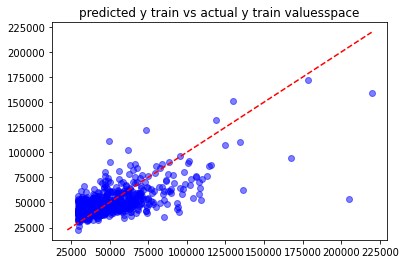

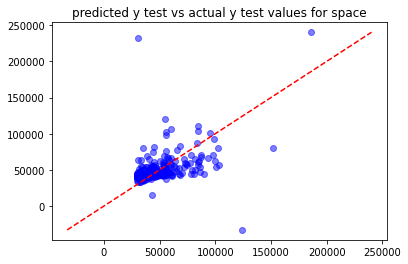

R2 score of model prediction on train set = 0.45432351953235117
R2 score of model prediction on test set = -0.2059886426359152
Degree:  3


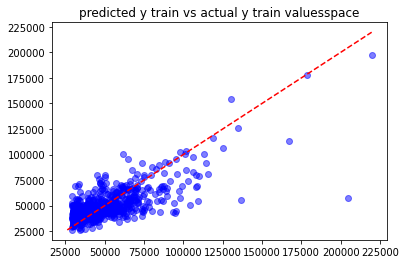

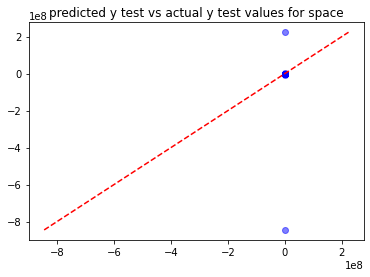

R2 score of model prediction on train set = 0.5297787866638395
R2 score of model prediction on test set = -6898258.379697987
Degree:  4


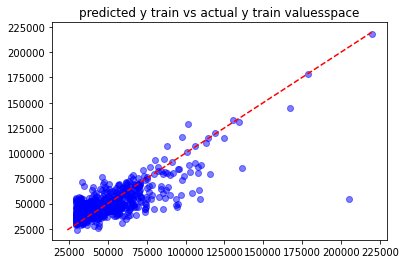

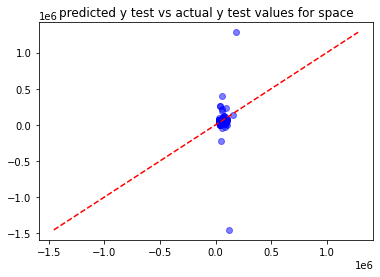

R2 score of model prediction on train set = 0.6202802685729278
R2 score of model prediction on test set = -36.60996991360662
Degree:  5


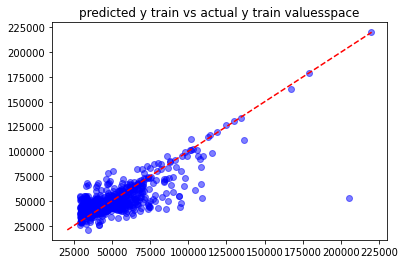

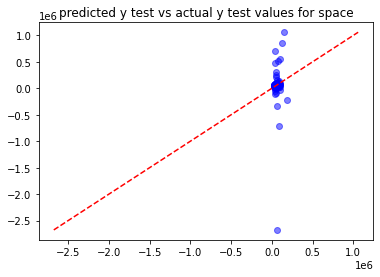

R2 score of model prediction on train set = 0.6379157176848698
R2 score of model prediction on test set = -99.49455566460428
Degree:  6


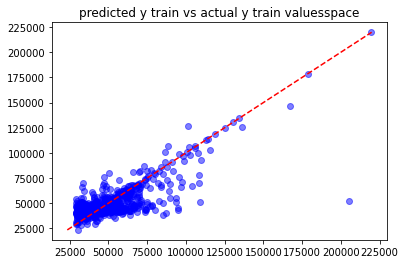

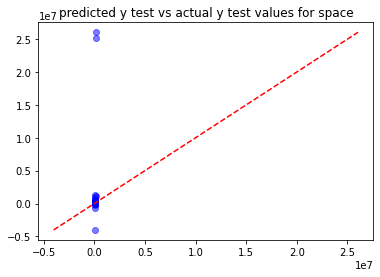

R2 score of model prediction on train set = 0.6207158254232127
R2 score of model prediction on test set = -11891.825904043588


In [54]:
degree = [2,3,4,5,6]
msqerror = []
for i, d in enumerate(degree):
    error = polyregression([spaceclean], ['space'], d)
    msqerror.append((d, error))

Degree:  2


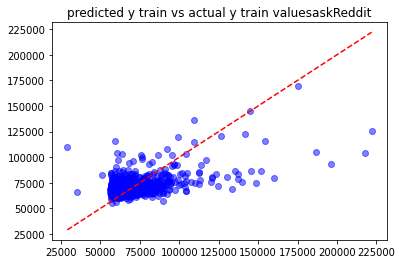

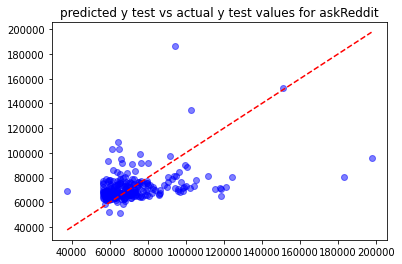

R2 score of model prediction on train set = 0.29007688034077506
R2 score of model prediction on test set = 0.03124922212848824
Degree:  3


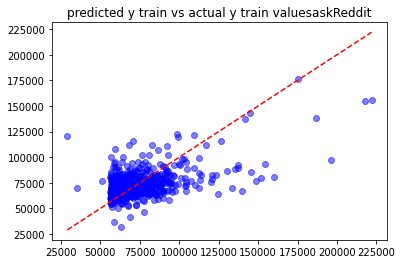

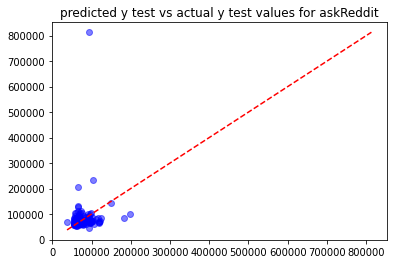

R2 score of model prediction on train set = 0.30347280295996926
R2 score of model prediction on test set = -6.624298826275795
Degree:  4


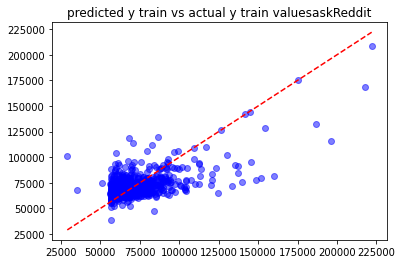

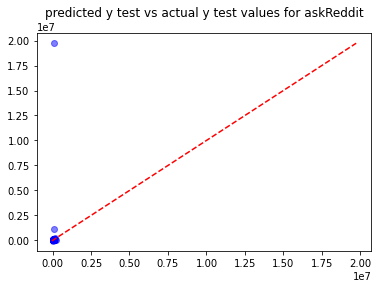

R2 score of model prediction on train set = 0.4100859430122912
R2 score of model prediction on test set = -4599.68927076116
Degree:  5


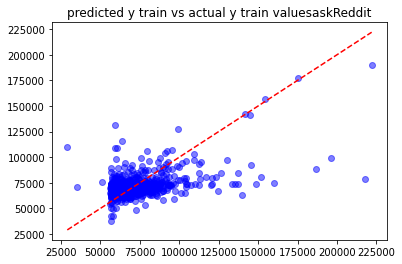

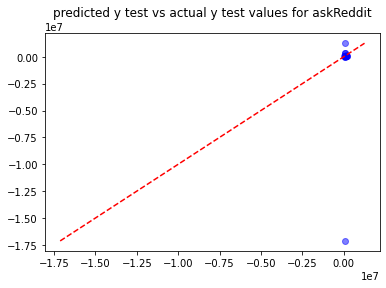

R2 score of model prediction on train set = 0.2429052570706688
R2 score of model prediction on test set = -3550.745436900394
Degree:  6


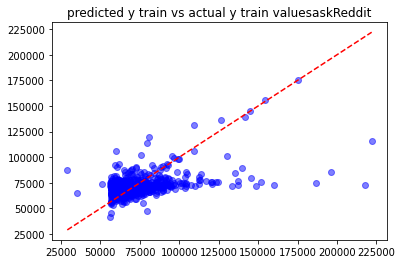

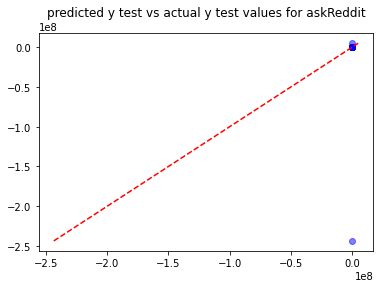

R2 score of model prediction on train set = 0.23422819163638786
R2 score of model prediction on test set = -707774.2105328618


In [56]:
degree = [2,3,4,5,6]
msqerror1 = []
for i, d in enumerate(degree):
    error = polyregression([askclean], ['askReddit'], d)
    msqerror1.append((d, error))

Degree:  2


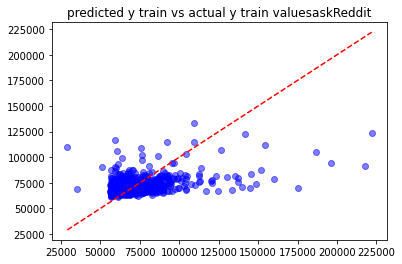

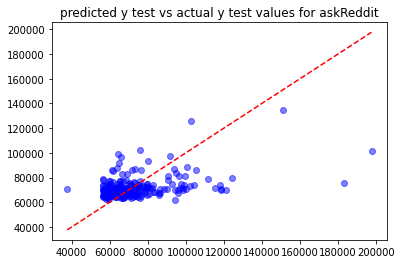

R2 score of model prediction on train set = 0.18823674481550168
R2 score of model prediction on test set = 0.18089168392760413
Degree:  3


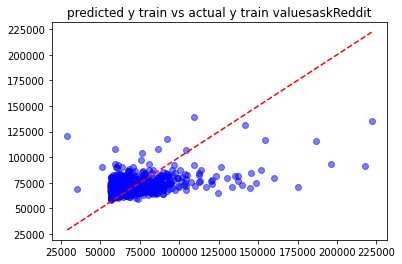

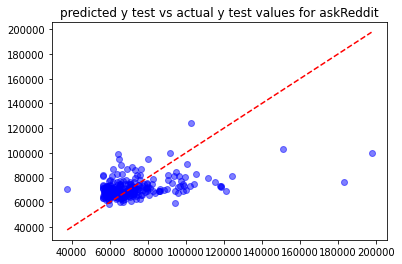

R2 score of model prediction on train set = 0.206025877463495
R2 score of model prediction on test set = 0.17100200923872666
Degree:  4


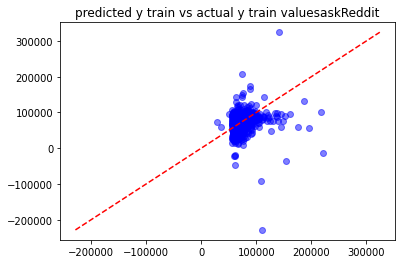

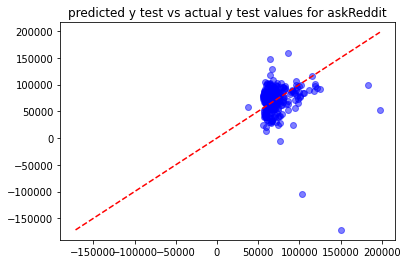

R2 score of model prediction on train set = -1.8718923587512917
R2 score of model prediction on test set = -2.6519426865477542
Degree:  5


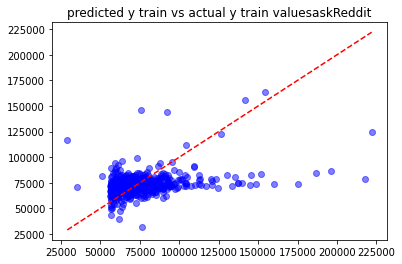

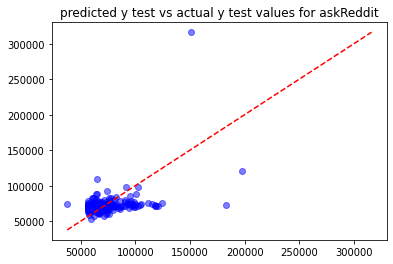

R2 score of model prediction on train set = 0.1307317403324525
R2 score of model prediction on test set = -0.10199117473049268
Degree:  6


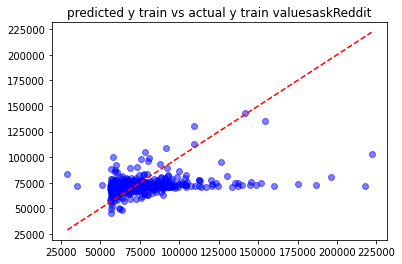

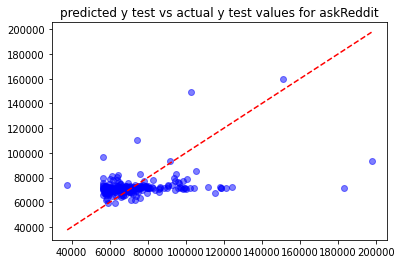

R2 score of model prediction on train set = 0.11839481271166741
R2 score of model prediction on test set = 0.12069418056773029


In [58]:
degree = [2,3,4,5,6]
msqerror2 = []
for i, d in enumerate(degree):
    error = polyregression([askclean[['score', 'num_comments', 'num_crossposts', 'number_words']]], ['askReddit'], d)
    msqerror2.append((d, error))


Degree:  2


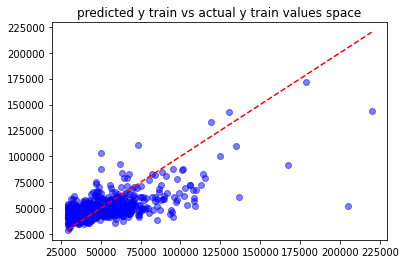

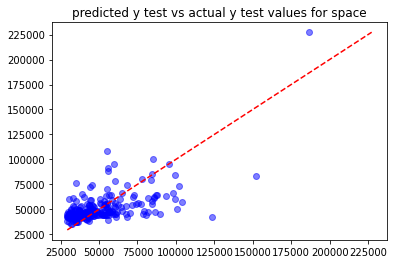

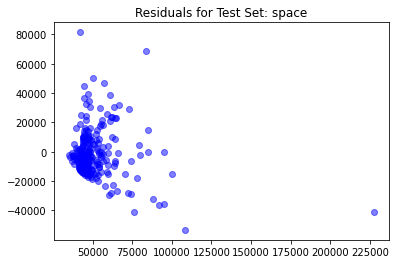

R2 score of model prediction on train set = 0.43517813148612783
R2 score of model prediction on test set = 0.3743779400394759
Degree:  3


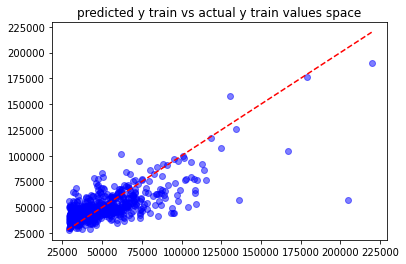

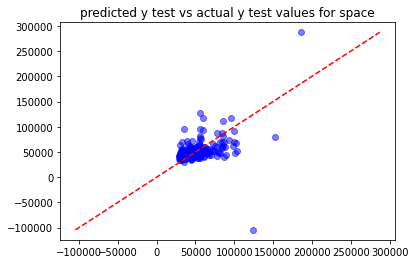

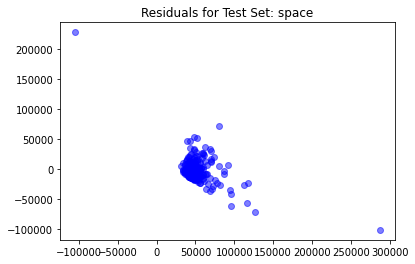

R2 score of model prediction on train set = 0.51962606910588
R2 score of model prediction on test set = -0.20524110909963444
Degree:  4


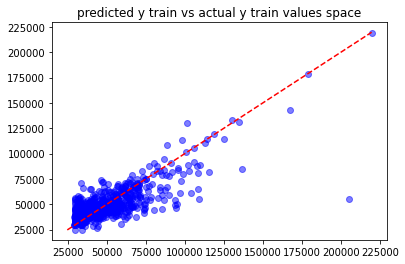

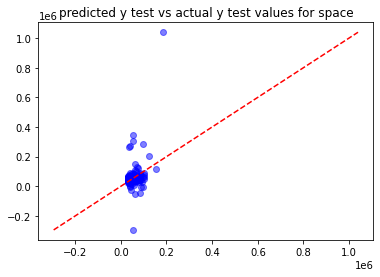

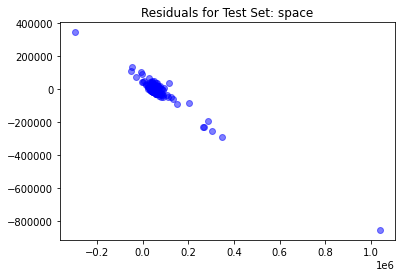

R2 score of model prediction on train set = 0.6241977193024217
R2 score of model prediction on test set = -10.636323773406778
Degree:  5


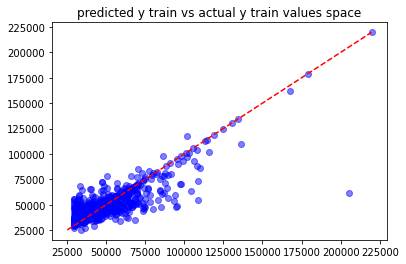

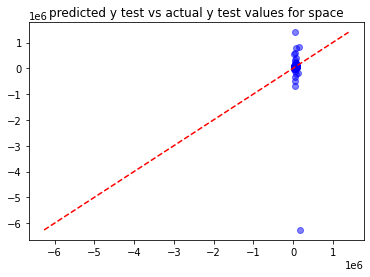

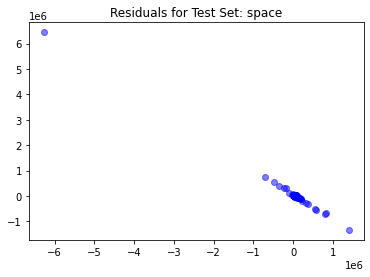

R2 score of model prediction on train set = 0.6884433114552759
R2 score of model prediction on test set = -418.70864392236723


In [108]:
degree = [2,3,4,5]
msqerror3 = []
for i, d in enumerate(degree):
    error = polyregressionridge([spaceclean], ['space'], d)
    msqerror3.append((d, error))

Degree:  2


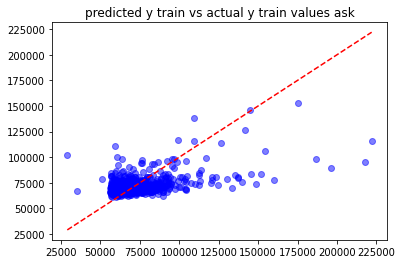

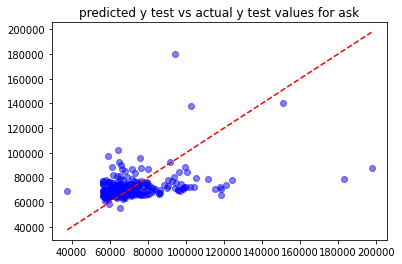

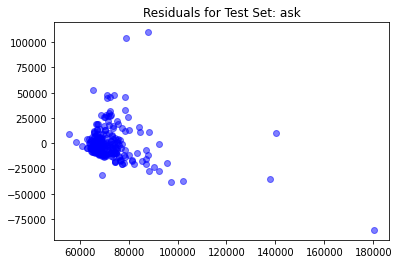

R2 score of model prediction on train set = 0.2783160077529456
R2 score of model prediction on test set = 0.05236456271781398
Degree:  3


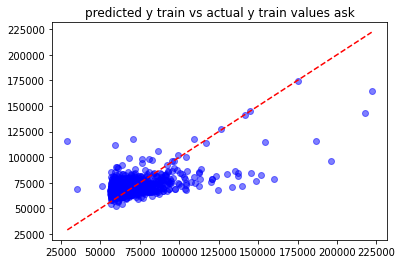

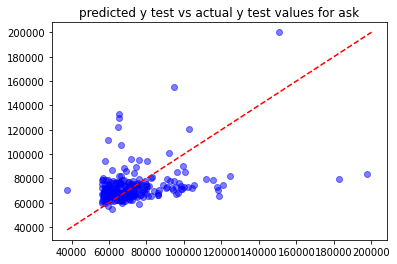

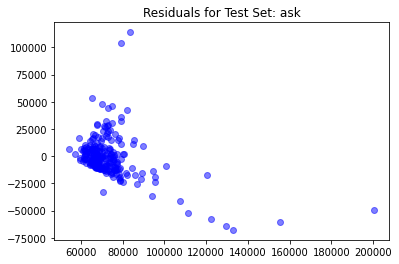

R2 score of model prediction on train set = 0.36767424415314376
R2 score of model prediction on test set = -0.09885044787590935
Degree:  4


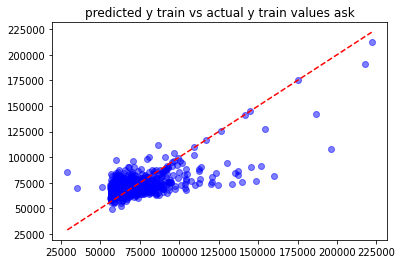

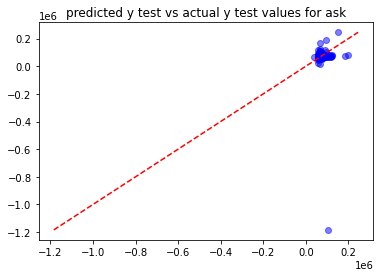

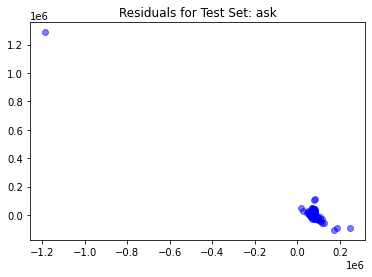

R2 score of model prediction on train set = 0.496635052339211
R2 score of model prediction on test set = -20.07413935057445
Degree:  5


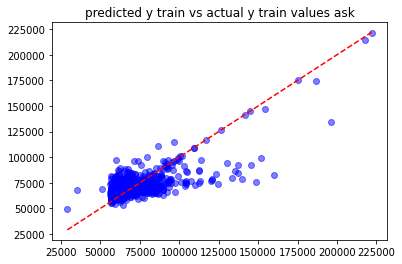

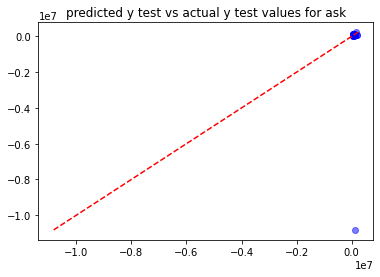

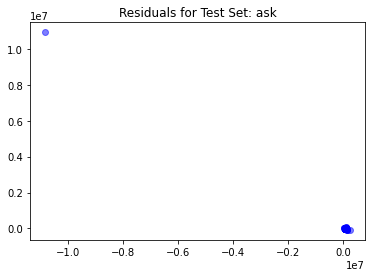

R2 score of model prediction on train set = 0.5664749627909047
R2 score of model prediction on test set = -1420.6355750633095


In [109]:
degree = [2,3,4,5]
msqerror3 = []
for i, d in enumerate(degree):
    error = polyregressionridge([askclean], ['ask'], d)
    msqerror3.append((d, error))

Degree:  2


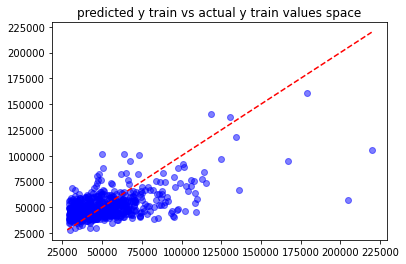

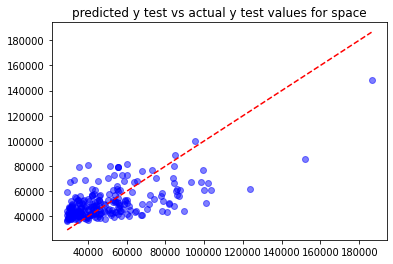

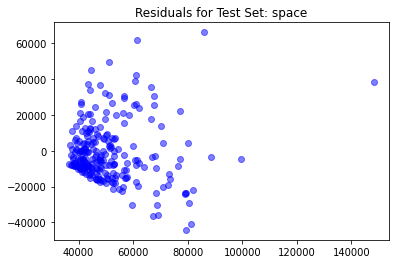

R2 score of model prediction on train set = 0.35772943169052085
R2 score of model prediction on test set = 0.37985452076107384
Degree:  3


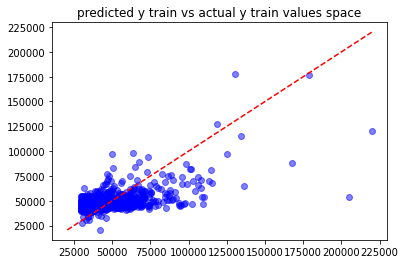

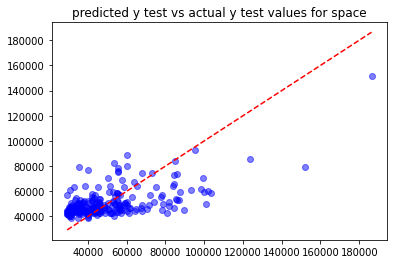

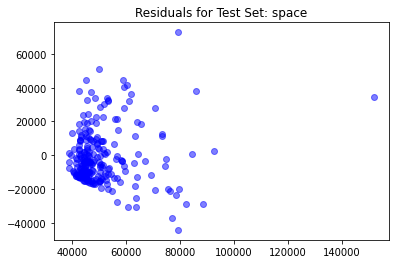

R2 score of model prediction on train set = 0.36794588879090107
R2 score of model prediction on test set = 0.38647016865369643
Degree:  4


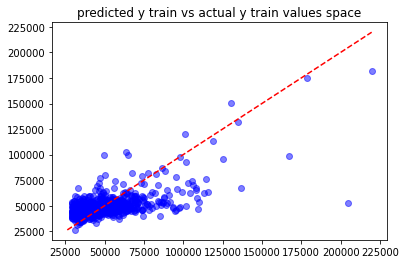

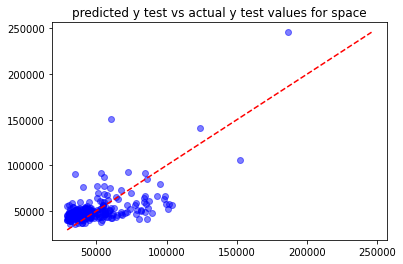

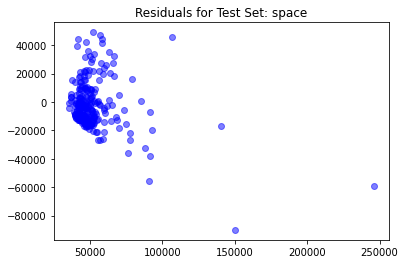

R2 score of model prediction on train set = 0.41457452555400287
R2 score of model prediction on test set = 0.3166919205393265
Degree:  5


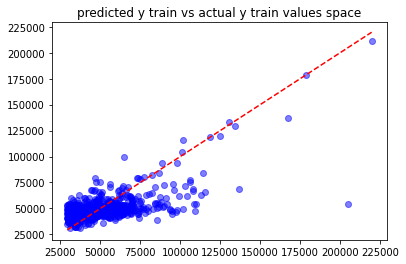

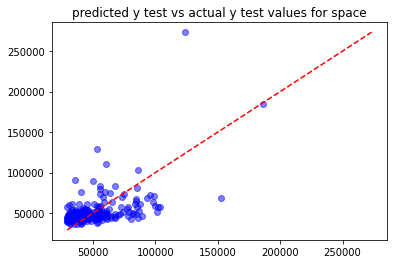

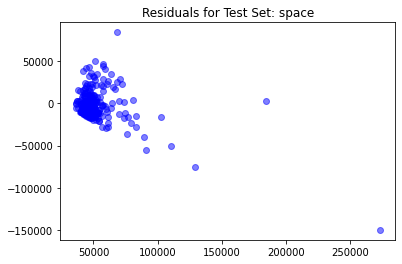

R2 score of model prediction on train set = 0.45452503300138236
R2 score of model prediction on test set = 0.10891859729190145


In [73]:
degree = [2,3,4,5]
msqerror4 = []
for i, d in enumerate(degree):
    error = polyregressionridge([spaceclean[['score', 'num_comments', 'num_crossposts', 'number_words']]], ['space'], d)
    msqerror4.append((d, error))

Degree:  2


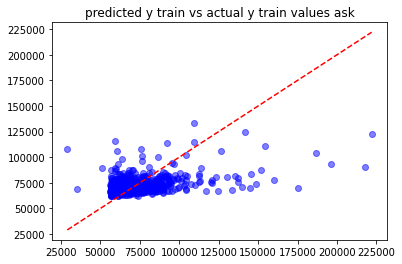

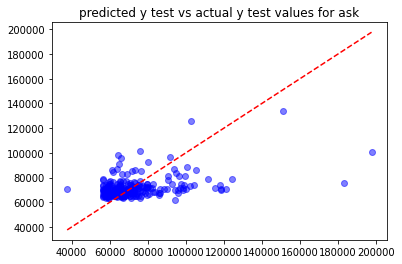

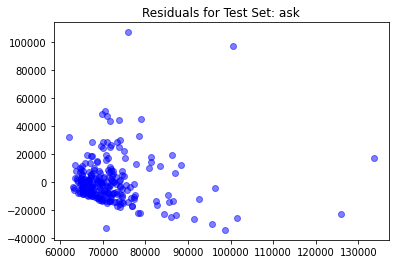

R2 score of model prediction on train set = 0.1880865420485759
R2 score of model prediction on test set = 0.1814936444884282
Degree:  3


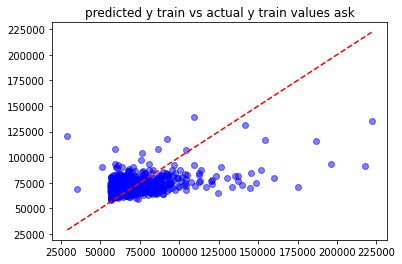

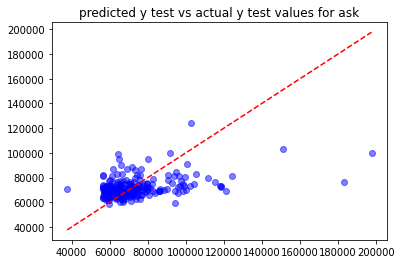

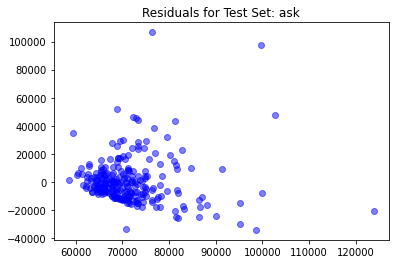

R2 score of model prediction on train set = 0.20602587688291085
R2 score of model prediction on test set = 0.17101636555492694
Degree:  4


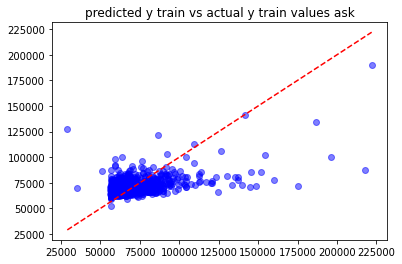

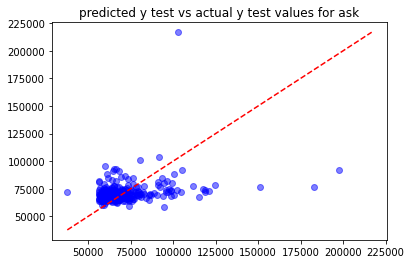

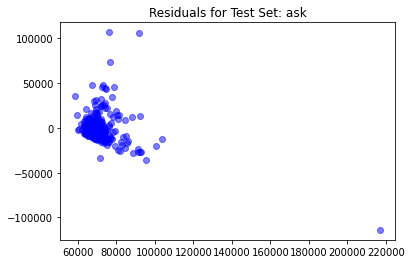

R2 score of model prediction on train set = 0.25005061633288916
R2 score of model prediction on test set = -0.06602415099733272
Degree:  5


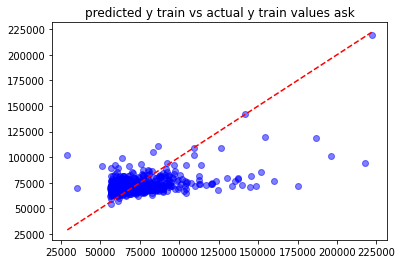

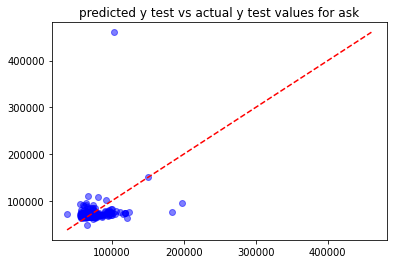

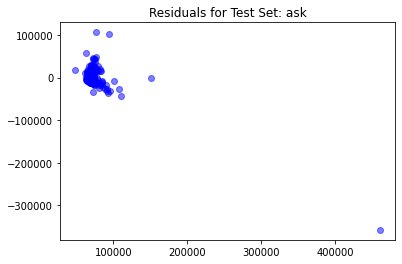

R2 score of model prediction on train set = 0.2715526688283042
R2 score of model prediction on test set = -1.3990225702127144


In [110]:
degree = [2,3,4,5]
msqerror4 = []
for i, d in enumerate(degree):
    error = polyregressionridge([askclean[['score', 'num_comments', 'num_crossposts', 'number_words']]], ['ask'], d)
    msqerror4.append((d, error))

t-sne in reducing 15 columns to 3 dimensions to produce cluster visualizations

In [141]:
# cleaning function specifically for this tsne

def cleandata1(redditcsv):
    redditcsv = redditcsv.drop(columns = ['is_bot'])
    redditcsv['body'] = redditcsv['body'].fillna(0)
    redditcsv['crosspost_subreddits'] = redditcsv['crosspost_subreddits'].fillna(False)
    redditcsv['is_image'] = np.where(redditcsv['post_type'] == 'image', 1, 0)
    redditcsv['is_link'] = np.where(redditcsv['post_type'] == 'link', 1, 0)
    redditcsv['is_text'] = np.where(redditcsv['post_type'] == 'text', 1, 0)
    redditcsv['is_vid'] = np.where(redditcsv['post_type'] == 'video', 1, 0)
    
    redditcsv['number_words'] = redditcsv['title'].apply(lambda x: len(x.split()))
    redditcsv.drop(columns = ['url', 'permalink', 'is_megathread'], inplace = True)
    redditcsv['created_utc'] = pd.to_datetime(redditcsv['created_utc'])
    redditcsv['created_utc_timeonly'] = redditcsv['created_utc'].dt.time
        
    redditcsv.loc[(redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-10 06:00:00').time()) & (redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 00:00:00').time()), 'late_night?'] = 1
    redditcsv.loc[redditcsv['late_night?'].isna(), 'late_night?'] = 0

    
    redditcsv.loc[(redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-10 12:00:00').time()) & (redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 06:00:00').time()), 'morning?'] = 1
    redditcsv.loc[redditcsv['morning?'].isna(), 'morning?'] = 0
    
    redditcsv.loc[(redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-10 18:00:00').time()) & (redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 12:00:00').time()), 'afternoon?'] = 1
    redditcsv.loc[redditcsv['afternoon?'].isna(), 'afternoon?'] = 0
    
    redditcsv.loc[(redditcsv['created_utc_timeonly'] >= pd.to_datetime('2023-11-10 18:00:00').time()) & (redditcsv['created_utc_timeonly'] < pd.to_datetime('2023-11-11 23:59:59').time()), 'evening?'] = 1
    redditcsv.loc[redditcsv['evening?'].isna(), 'evening?'] = 0
   

    redditcsv.loc[redditcsv['body'] != 0, 'body_fill?'] = 1
    redditcsv.loc[redditcsv['body'] == 0, 'body_fill?'] = 0
                                                        
    redditcsv['is_nsfw'] = redditcsv['is_nsfw'].astype(int)

    redditcsv.loc[redditcsv['crosspost_subreddits'] == False, 'crossposted?'] = 0
    redditcsv.loc[redditcsv['crosspost_subreddits'] != False, 'crossposted?'] = 1
    
    redditcsv.loc[redditcsv['subreddit'] == 'space', 'subreddit'] = 0
    redditcsv.loc[redditcsv['subreddit'] == 'AskReddit', 'subreddit'] = 1
    redditcsv.loc[redditcsv['subreddit'] == 'aww', 'subreddit'] = 2
    redditcsv.loc[redditcsv['subreddit'] == 'Music', 'subreddit'] = 3
    redditcsv.loc[redditcsv['subreddit'] == 'gaming', 'subreddit'] = 4

    redditcsv.drop(columns = ['id', 'title', 'upvote_ratio', 'created_utc', 'subscribers', 'domain', 'num_awards', 'crosspost_subreddits', 'created_utc_timeonly', 'body', 'post_type'], inplace = True)
    
    return redditcsv
    

In [142]:
spaceclean1 = cleandata1(space)
askclean1 = cleandata1(AskReddit)
gamingclean1 = cleandata1(gaming)
awwclean1 = cleandata1(aww)
musicclean1 = cleandata1(Music)

/var/folders/z_/c3wvqjy50m776ff_2rbr_qfc0000gn/T/ipykernel_2474/1151339952.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  redditcsv['crosspost_subreddits'] = redditcsv['crosspost_subreddits'].fillna(False)


In [146]:
allfive = pd.concat([spaceclean1,askclean1,gamingclean1,awwclean1,musicclean1])
allfive = allfive.reset_index(drop=True)

spaceindex = allfive[allfive['subreddit'] == 0].index
askindex =  allfive[allfive['subreddit'] == 1].index
awwindex = allfive[allfive['subreddit'] == 2].index
musicindex = allfive[allfive['subreddit'] == 3].index
gamingindex = allfive[allfive['subreddit'] == 4].index


allfive.drop(columns = ['subreddit'], inplace = True)
allfive_embedded = TSNE(n_components = 3, learning_rate = 'auto', init = 'random', perplexity = 50).fit_transform(allfive)




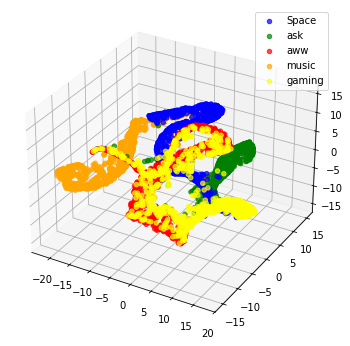

In [147]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each dataset with different colors and markers
# t-sne for combined dataset with perplexity = 50

ax.scatter(allfive_embedded[spaceindex,0], allfive_embedded[spaceindex,1], allfive_embedded[spaceindex,2], label = 'Space', color = 'blue', alpha=0.7)
ax.scatter(allfive_embedded[askindex,0], allfive_embedded[askindex,1], allfive_embedded[askindex,2], label = 'ask', color = 'green', alpha=0.7)
ax.scatter(allfive_embedded[awwindex,0], allfive_embedded[awwindex,1], allfive_embedded[awwindex,2], label = 'aww', color = 'red', alpha=0.7)
ax.scatter(allfive_embedded[musicindex,0], allfive_embedded[musicindex,1], allfive_embedded[musicindex,2], label = 'music', color = 'orange', alpha=0.7)
ax.scatter(allfive_embedded[gamingindex,0], allfive_embedded[gamingindex,1], allfive_embedded[gamingindex,2], label = 'gaming', color = 'yellow', alpha=0.7)

ax.legend()
plt.show()

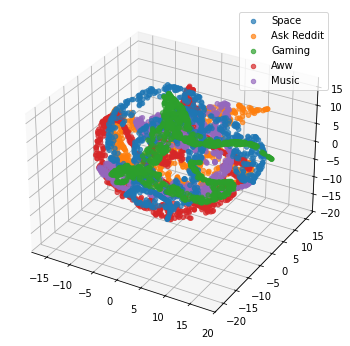

In [121]:
spaceclean_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=20).fit_transform(spaceclean)
askclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=20).fit_transform(askclean)
gamingclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=20).fit_transform(gamingclean)
awwclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=20).fit_transform(awwclean)
musicclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=20).fit_transform(musicclean)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each dataset with different colors and markers
ax.scatter(spaceclean_embedded[:,0], spaceclean_embedded[:,1], spaceclean_embedded[:,2], label = 'Space', alpha=0.7)
ax.scatter(askclean_embedded[:,0], askclean_embedded[:,1], askclean_embedded[:,2], label = 'Ask Reddit', alpha=0.7)
ax.scatter(gamingclean_embedded[:,0], gamingclean_embedded[:,1], gamingclean_embedded[:,2], label = 'Gaming', alpha=0.7)
ax.scatter(awwclean_embedded[:,0], awwclean_embedded[:,1], awwclean_embedded[:,2], label = 'Aww', alpha=0.7)
ax.scatter(musicclean_embedded[:,0], musicclean_embedded[:,1], musicclean_embedded[:,2], label = 'Music', alpha=0.7)


# Add a legend to differentiate datasets
ax.legend()

plt.show()

# 3d tsne, different iterations with varying perplexity

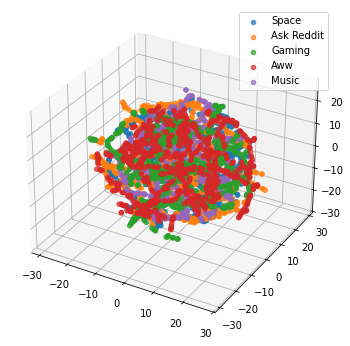

In [142]:
spaceclean_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(spaceclean)
askclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=5).fit_transform(askclean)
gamingclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=5).fit_transform(gamingclean)
awwclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=5).fit_transform(awwclean)
musicclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=5).fit_transform(musicclean)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(spaceclean_embedded[:,0], spaceclean_embedded[:,1], spaceclean_embedded[:,2], label = 'Space', alpha=0.7)
ax.scatter(askclean_embedded[:,0], askclean_embedded[:,1], askclean_embedded[:,2], label = 'Ask Reddit', alpha=0.7)
ax.scatter(gamingclean_embedded[:,0], gamingclean_embedded[:,1], gamingclean_embedded[:,2], label = 'Gaming', alpha=0.7)
ax.scatter(awwclean_embedded[:,0], awwclean_embedded[:,1], awwclean_embedded[:,2], label = 'Aww', alpha=0.7)
ax.scatter(musicclean_embedded[:,0], musicclean_embedded[:,1], musicclean_embedded[:,2], label = 'Music', alpha=0.7)



ax.legend()

plt.show()



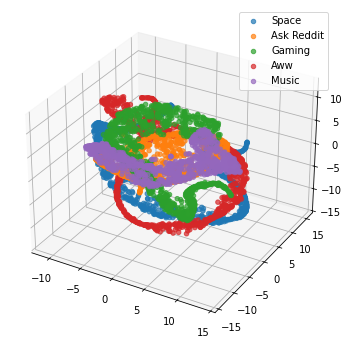

In [143]:
spaceclean_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(spaceclean)
askclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=50).fit_transform(askclean)
gamingclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=50).fit_transform(gamingclean)
awwclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=50).fit_transform(awwclean)
musicclean_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=50).fit_transform(musicclean)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each dataset with different colors and markers
ax.scatter(spaceclean_embedded[:,0], spaceclean_embedded[:,1], spaceclean_embedded[:,2], label = 'Space', alpha=0.7)
ax.scatter(askclean_embedded[:,0], askclean_embedded[:,1], askclean_embedded[:,2], label = 'Ask Reddit', alpha=0.7)
ax.scatter(gamingclean_embedded[:,0], gamingclean_embedded[:,1], gamingclean_embedded[:,2], label = 'Gaming', alpha=0.7)
ax.scatter(awwclean_embedded[:,0], awwclean_embedded[:,1], awwclean_embedded[:,2], label = 'Aww', alpha=0.7)
ax.scatter(musicclean_embedded[:,0], musicclean_embedded[:,1], musicclean_embedded[:,2], label = 'Music', alpha=0.7)


# Add a legend to differentiate datasets
ax.legend()

plt.show()

In [119]:
# random forest
# new: tuned model's parameters using gridsearchcv to find best parameters for random forest regression model
# lowered n_estimators, reduced depth, increase min_samples to try to decrease overfitting

In [140]:
# break up the gridsearch from randomforest into a new cell
# use r2 score 

# generate a plain random forest regressor, train test split, set a random state in regressor, n estimators at 
# 200, max depth at 10 and look at r2 score
# adjust max depth
# after find a good amount of range and then do gridsearchcv with these different parameters 
# mention random forest regressor as best in report

# 5, 7, 9, 10 as max_depth options
# 200 - 300,  600 - 800 as n_estimator options, r2 score doesn't change too much after that

In [81]:
x = spaceclean.copy()
y = x.score
x.drop(columns = ['score'], inplace = True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [99]:

# plain regressor to determine potential best parameters to gridsearchcv


regressor = RandomForestRegressor(n_estimators = 500, max_depth = 4, min_samples_split = 2, min_samples_leaf = 3, oob_score = True, random_state = 42)
regressor.fit(X_train, y_train)
y_predict_test = regressor.predict(X_test)
print("R2 score of model prediction on test set =", r2_score(y_test, y_predict_test))

R2 score of model prediction on test set = 0.4039383704250985


In [12]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
def traintestsplit(df, name):
    print(name)
    print()
    
    x = df.copy()
    y = x.score
    x.drop(columns = ['score'], inplace = True)
        
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [101]:
def findparam(X_train, y_train):
    regressor = RandomForestRegressor(oob_score = True)
    param_grid = {
        'n_estimators': [200, 300, 600, 700, 800],
        'max_depth': [5, 7, 9, 10],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 3]
    }
        
    grid_search = GridSearchCV(regressor, param_grid, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    
    best_regressor = grid_search.best_estimator_
    
    print('best parameters: ', grid_search.best_params_)

    print('Out of bag score: ', best_regressor.oob_score_)
    
    return best_regressor
        

In [102]:
def randomforest(best_regressor, X_train, X_test, y_train, y_test, df):


    y_pred_test = best_regressor.predict(X_test)


    y_pred_train = best_regressor.predict(X_train)

    plt.scatter(y_test, y_pred_test, color = 'blue', alpha = 0.5)
    min_val = min(min(y_test), min(y_pred_test))  # Find the minimum value for both axes
    max_val = max(max(y_test), max(y_pred_test))  # Find the maximum value for both axes
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.title('predicted y test vs actual y test values')
    plt.show()

    plt.scatter(y_pred_test, y_test - y_pred_test, color='blue', alpha=0.5)
    plt.title(f'Residuals for Test Set: ')
    plt.show()

    print("R2 score of model prediction on train set =", r2_score(y_train, y_pred_train))
    print("R2 score of model prediction on test set =", r2_score(y_test, y_pred_test))

        
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(X_train, y_train)
    y_dummy_test = dummy_regr.predict(X_test)



    print("R2 score of dummy prediction on test set =", r2_score(y_test, y_dummy_test))

    print(f'Mean Squared Error: ', mean_squared_error(y_test, y_pred_test))

    for c, b in enumerate(best_regressor.feature_importances_):
        print('Feature importance of feature', df.columns[c],':',b)

           
        

space

best parameters:  {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 200}
Out of bag score:  0.28681657825643847


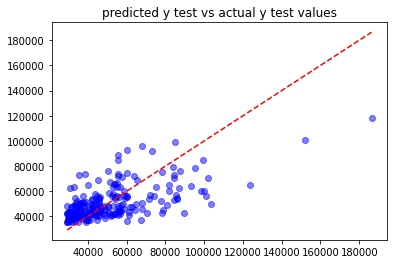

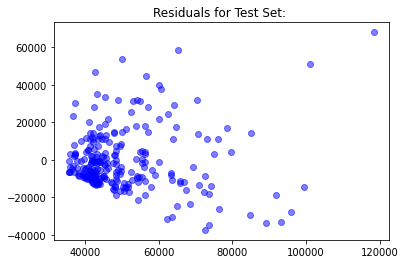

R2 score of model prediction on train set = 0.5337786454130315
R2 score of model prediction on test set = 0.4109000872894526
R2 score of dummy prediction on test set = -4.24463055703761e-06
Mean Squared Error:  263119330.2546216
Feature importance of feature score : 0.40334042585629665
Feature importance of feature num_comments : 0.38782072417001806
Feature importance of feature num_crossposts : 0.0
Feature importance of feature is_nsfw : 0.049590523165984626
Feature importance of feature is_image : 0.021284378218551895
Feature importance of feature is_link : 0.00011895621243560882
Feature importance of feature is_text : 0.0046521786574160225
Feature importance of feature is_vid : 0.10320290519442633
Feature importance of feature number_words : 0.0217795750638262
Feature importance of feature late_night? : 0.000993563714196588
Feature importance of feature morning? : 0.002982965745707011
Feature importance of feature afternoon? : 0.0035175107008014288
Feature importance of feature even

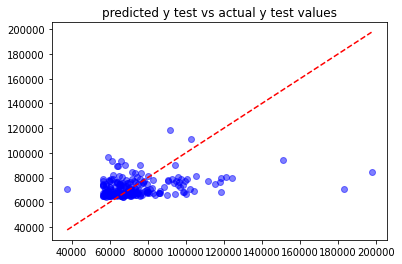

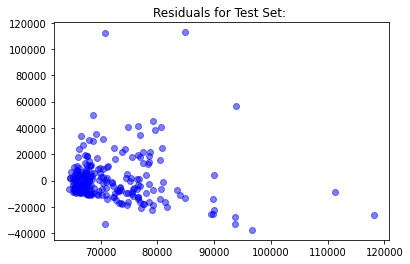

R2 score of model prediction on train set = 0.41537671530296383
R2 score of model prediction on test set = 0.09768281935767098
R2 score of dummy prediction on test set = -0.0001282356317184874
Mean Squared Error:  306990686.54152024
Feature importance of feature score : 0.18051696659583372
Feature importance of feature num_comments : 0.43290662406193076
Feature importance of feature num_crossposts : 0.0021678672070630893
Feature importance of feature is_nsfw : 0.0
Feature importance of feature is_image : 0.0
Feature importance of feature is_link : 0.0
Feature importance of feature is_text : 0.0
Feature importance of feature is_vid : 0.2450136121312985
Feature importance of feature number_words : 0.009473539943483468
Feature importance of feature late_night? : 0.00195246611049956
Feature importance of feature morning? : 0.014248643588761059
Feature importance of feature afternoon? : 0.018111634089291957
Feature importance of feature evening? : 0.09560864627183789
Feature importance of f

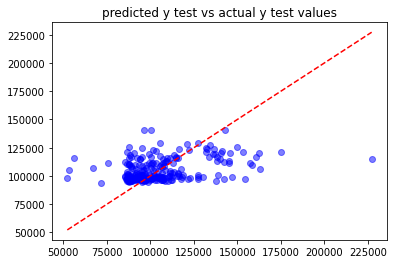

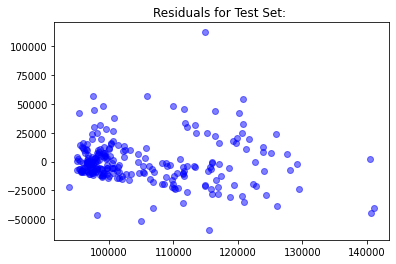

R2 score of model prediction on train set = 0.428485921879603
R2 score of model prediction on test set = 0.12655342763818211
R2 score of dummy prediction on test set = -0.00020899342567126666
Mean Squared Error:  379606043.0229294
Feature importance of feature score : 0.41619254927624183
Feature importance of feature num_comments : 0.40262691239470455
Feature importance of feature num_crossposts : 3.566721634600376e-05
Feature importance of feature is_nsfw : 0.0037094749891183262
Feature importance of feature is_image : 0.001966178334887342
Feature importance of feature is_link : 0.006257212871182311
Feature importance of feature is_text : 0.0
Feature importance of feature is_vid : 0.13205120483365054
Feature importance of feature number_words : 0.012236627399407988
Feature importance of feature late_night? : 0.004118338347892718
Feature importance of feature morning? : 0.0026864907461179696
Feature importance of feature afternoon? : 0.009271639156947956
Feature importance of feature e

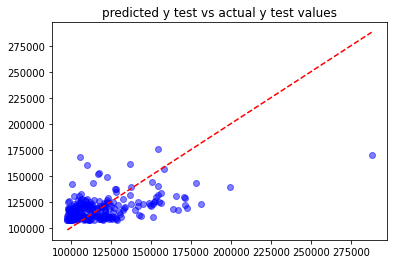

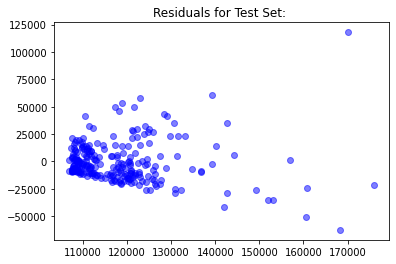

R2 score of model prediction on train set = 0.5752096990037041
R2 score of model prediction on test set = 0.2166593015756192
R2 score of dummy prediction on test set = -0.0008777852265546837
Mean Squared Error:  366571786.57870877
Feature importance of feature score : 0.3363112022532756
Feature importance of feature num_comments : 0.5542094191652746
Feature importance of feature num_crossposts : 0.0
Feature importance of feature is_nsfw : 0.02287419276678135
Feature importance of feature is_image : 0.0017285244428463663
Feature importance of feature is_link : 0.0
Feature importance of feature is_text : 0.0028254581196480466
Feature importance of feature is_vid : 0.07228053166526356
Feature importance of feature number_words : 0.004117010675123864
Feature importance of feature late_night? : 0.001342878981688877
Feature importance of feature morning? : 0.002182119761040322
Feature importance of feature afternoon? : 0.0021286621690574828
Feature importance of feature evening? : 0.0
Featur

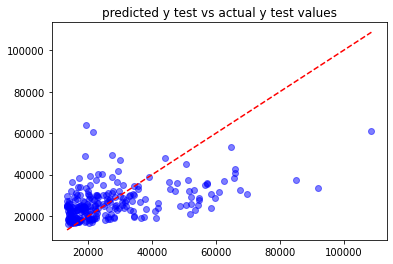

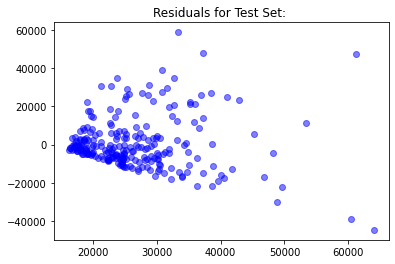

R2 score of model prediction on train set = 0.4832358307061052
R2 score of model prediction on test set = 0.22286874889291364
R2 score of dummy prediction on test set = -4.267546862557481e-06
Mean Squared Error:  184063423.47772473
Feature importance of feature score : 0.5200915832487927
Feature importance of feature num_comments : 0.2827615026347159
Feature importance of feature num_crossposts : 6.095984514220775e-05
Feature importance of feature is_nsfw : 0.0
Feature importance of feature is_image : 0.009217460109375358
Feature importance of feature is_link : 0.00607227813424482
Feature importance of feature is_text : 0.0
Feature importance of feature is_vid : 0.11582663059955009
Feature importance of feature number_words : 0.015711511625168546
Feature importance of feature late_night? : 0.002710642520500737
Feature importance of feature morning? : 0.03413284509368277
Feature importance of feature afternoon? : 0.004411111493389878
Feature importance of feature evening? : 0.0090034746

In [103]:
x = [spaceclean, askclean, gamingclean, awwclean, musicclean]
xnames = ['space', 'ask', 'gaming', 'aww', 'music']


for i, d in enumerate(x):
    X_train, X_test, y_train, y_test = traintestsplit(d, xnames[i])
    best_regressor = findparam(X_train, y_train)
    randomforest(best_regressor, X_train, X_test, y_train, y_test, d)

space

best parameters:  {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 800}
Out of bag score:  0.2580581711374268


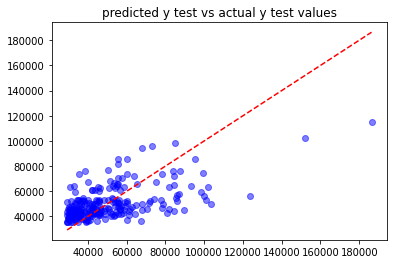

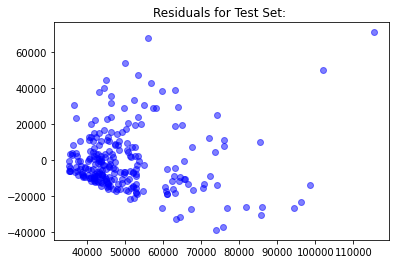

R2 score of model prediction on train set = 0.5025436861422028
R2 score of model prediction on test set = 0.34487163147041944
R2 score of dummy prediction on test set = -4.24463055703761e-06
Mean Squared Error:  292610699.5419011
Feature importance of feature score : 0.42598391281415016
Feature importance of feature num_comments : 0.4393449997599461
Feature importance of feature num_crossposts : 0.13467108742590372
ask

best parameters:  {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 700}
Out of bag score:  0.11243780981674234


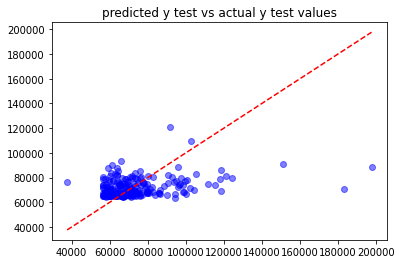

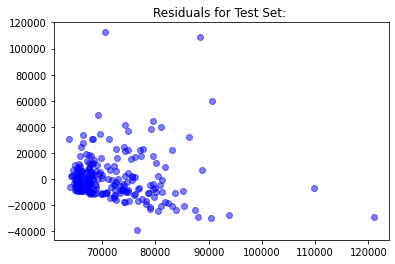

R2 score of model prediction on train set = 0.40240141097831295
R2 score of model prediction on test set = 0.10209969362334348
R2 score of dummy prediction on test set = -0.0001282356317184874
Mean Squared Error:  305487956.3571951
Feature importance of feature score : 0.25853423713749146
Feature importance of feature num_comments : 0.4598310119448862
Feature importance of feature num_crossposts : 0.2816347509176223
gaming

best parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 800}
Out of bag score:  0.15165459662801994


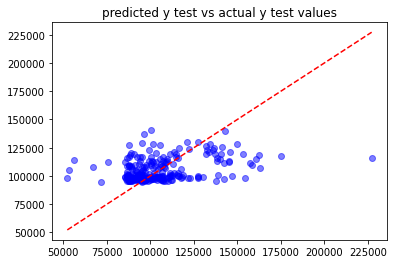

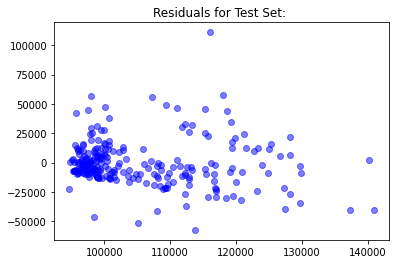

R2 score of model prediction on train set = 0.41677049431573565
R2 score of model prediction on test set = 0.12238728287163136
R2 score of dummy prediction on test set = -0.00020899342567126666
Mean Squared Error:  381416678.93305105
Feature importance of feature score : 0.44066288390765573
Feature importance of feature num_comments : 0.4179830326191068
Feature importance of feature num_crossposts : 0.1413540834732375
aww

best parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Out of bag score:  0.3666781954777818


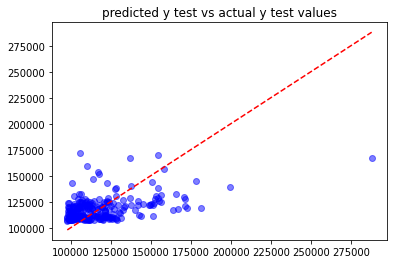

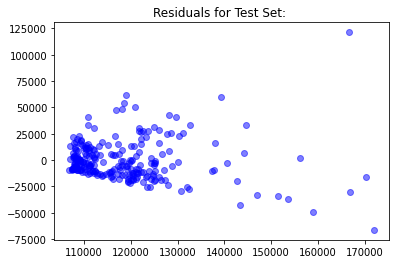

R2 score of model prediction on train set = 0.596258239531698
R2 score of model prediction on test set = 0.19961777489061827
R2 score of dummy prediction on test set = -0.0008777852265546837
Mean Squared Error:  374546532.2998422
Feature importance of feature score : 0.3401663349936609
Feature importance of feature num_comments : 0.5703006107812333
Feature importance of feature num_crossposts : 0.08953305422510588
music

best parameters:  {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 700}
Out of bag score:  0.2321765922095398


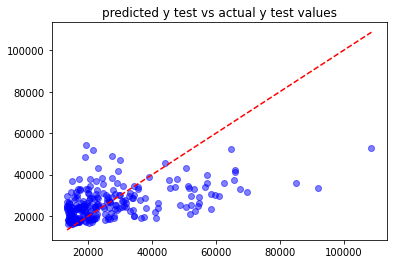

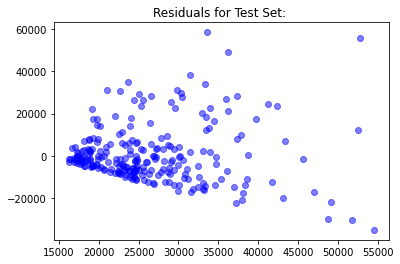

R2 score of model prediction on train set = 0.4611253658031076
R2 score of model prediction on test set = 0.23014233250339156
R2 score of dummy prediction on test set = -4.267546862557481e-06
Mean Squared Error:  182340676.26045763
Feature importance of feature score : 0.5726473317264884
Feature importance of feature num_comments : 0.2896979103285159
Feature importance of feature num_crossposts : 0.13765475794499568


In [114]:
for i, d in enumerate(x1):
    X_train, X_test, y_train, y_test = traintestsplit(d, xnames[i])
    best_regressor = findparam(X_train, y_train)
    randomforest(best_regressor, X_train, X_test, y_train, y_test, d)